## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [253]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Calibrate the camera using the objpoints and imgpoints


Text(0.5,1,'Undistorted')

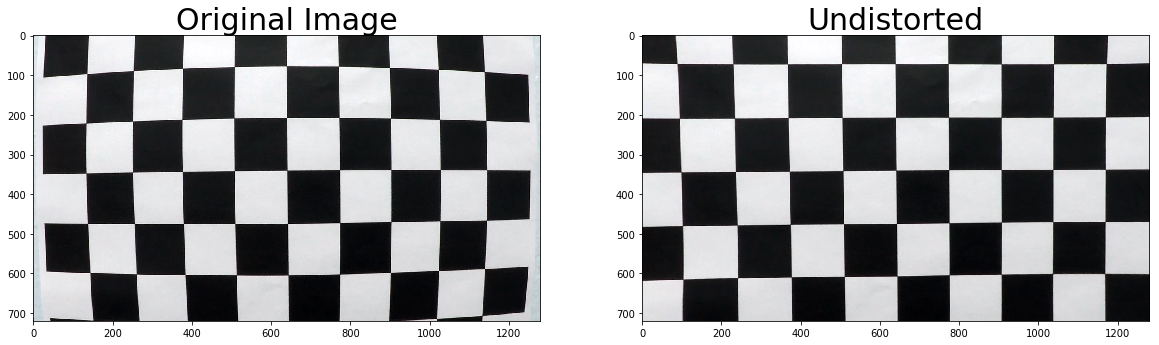

In [254]:
%matplotlib inline

img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imsave("./output_images/camera_calibrated_img.jpg", dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted', fontsize=30)

## Threshold methods

In [301]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

    abs_sobel = np.absolute(sobel)

    # scale the image to 8 bit (0 - 255)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    #create a binary mask where the threshold parameters are met
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return grad_binary



def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # combine sobelx and sobely, to get the grad_mag
    gradmag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag / scale_factor).astype(np.uint8)
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi / 2)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # Use arctan to get the direction of the gradient
    gradient_direction = np.arctan2(abs_sobely, abs_sobelx)
    
    # create a binary mask based on the thresholds passed
    dir_binary = np.zeros_like(gradient_direction)
    dir_binary[(gradient_direction >= thresh[0]) & (gradient_direction <= thresh[1])] = 1
    return dir_binary

def hls_select(img, thresh=(0, 255), channel='S'):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    if channel == 'H':
        channel = H
    elif channel == 'L':
        channel = L
    else:
        channel = S
    
    # 2) Apply a threshold to the S channel
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    #binary_output = np.copy(img) # placeholder line
    return binary

def rgb_select(img, thresh=(0, 255), channel='R'):
    # 1) Convert to HLS color space
    
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    
    if channel == 'R':
        channel = R
    elif channel == 'G':
        channel = G
    else:
        channel = B
    
    # 2) Apply a threshold to the S channel
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    #binary_output = np.copy(img) # placeholder line
    return binary

def plot_images_three(images, titles):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
    ax1.imshow(images[0])
    ax1.set_title(titles[0], fontsize=30)
    ax2.imshow(images[1])
    ax2.set_title(titles[1], fontsize=30)
    ax3.imshow(images[2])
    ax3.set_title(titles[2], fontsize=30)

def color_gradient_transform(img):
    ksize = 7
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(40, 130))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(40, 100))
    # print(gradx, grady)

    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(40, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))

    hue_binary = hls_select(img, thresh=(90, 130), channel='H')
    light_binary = hls_select(img, thresh=(115, 255), channel='L')
    sat_binary = hls_select(img, thresh=(70, 255), channel='S')


    red_binary = rgb_select(img, thresh=(90, 130), channel='R')
    blue_binary = rgb_select(img, thresh=(130, 255), channel='G')
    green_binary = rgb_select(img, thresh=(70, 255), channel='B')

    combined = np.zeros_like(dir_binary)
    combined[(((mag_binary == 1) | (blue_binary == 1) | (sat_binary == 1)) & ((dir_binary == 1) | ((sat_binary == 1)) & (light_binary == 1)) 
         )] = 1
    
    return combined
    

## Testing the threshold methods

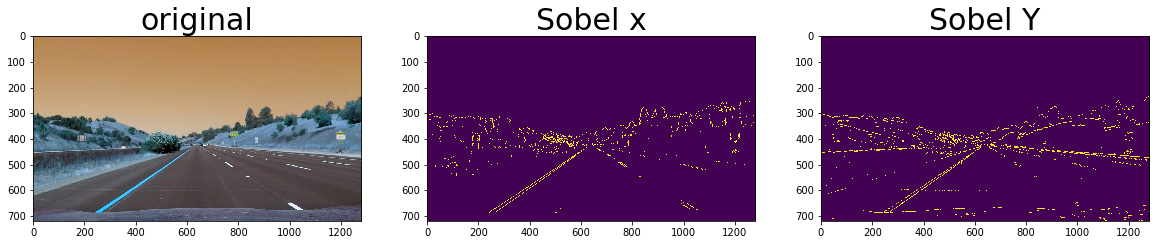

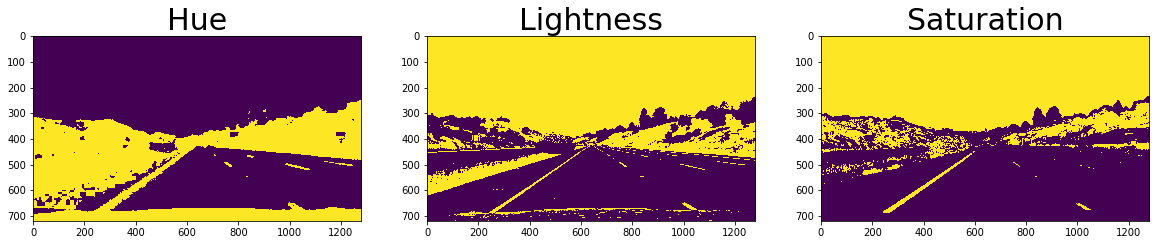

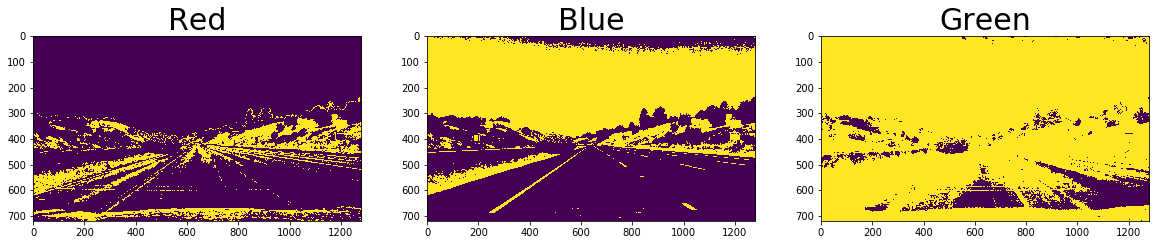

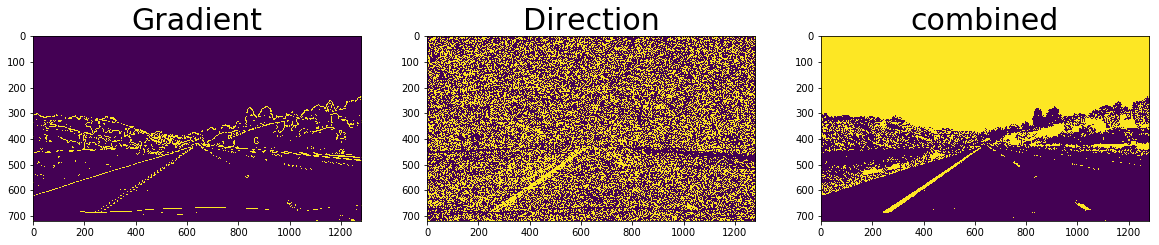

In [302]:
%matplotlib inline


ksize = 7
image = cv2.imread('./test_images/straight_lines1.jpg')

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(40, 130))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(40, 100))
# print(gradx, grady)

mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(40, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

hue_binary = hls_select(image, thresh=(90, 130), channel='H')
light_binary = hls_select(image, thresh=(115, 255), channel='L')
sat_binary = hls_select(image, thresh=(70, 255), channel='S')


red_binary = rgb_select(image, thresh=(90, 130), channel='R')
blue_binary = rgb_select(image, thresh=(130, 255), channel='G')
green_binary = rgb_select(image, thresh=(70, 255), channel='B')

combined = color_gradient_transform(image)

plot_images_three([image, gradx, grady],
                  ["original", "Sobel x", "Sobel Y"])

plot_images_three([hue_binary, light_binary, sat_binary],
                  ["Hue", "Lightness", "Saturation"])

plot_images_three([red_binary, blue_binary, green_binary],
                  ["Red", "Blue", "Green"])

plot_images_three([mag_binary, dir_binary, combined],
                  ["Gradient", "Direction", "combined"])


## Perspective transform to get the bird's eye  view

In [303]:
def warp_img(img, src, dst):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

## Test perspective transform

Text(0.5,1,'Warped Img')

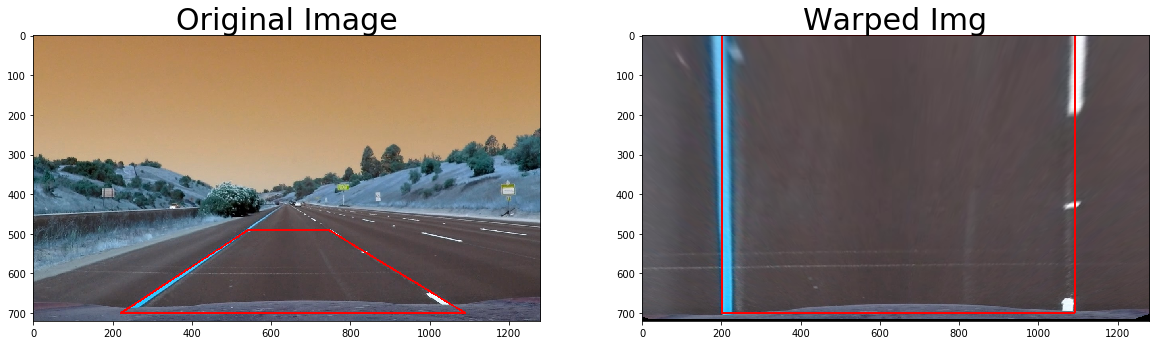

In [304]:
%matplotlib inline

img = cv2.imread('./test_images/straight_lines1.jpg')
cv2.imshow("Original", img)
src = [[746, 491],
       [1090, 700],
       [220, 700],
       [540, 491]]
dst = [[1090, 0], [1090, 700], [200, 700],[200, 0]] 

warped_img = warp_img(img, np.float32(src), np.float32(dst))

pts = np.array(src, np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(img,[pts],True,(255,0,0),3)

pts = np.array(dst, np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(warped_img,[pts],True,(255,0,0),3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped_img)
ax2.set_title('Warped Img', fontsize=30)

## Sliding window

In [305]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0] // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                      (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low),
                      (win_xright_high, win_y_high), (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, show_window=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    
    # Plots the left and right polynomials on the lane lines
    if show_window:
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        print(rightx[1] - leftx[1])

    return out_img, left_fitx, right_fitx, left_fit, right_fit, ploty



# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([2.13935315e-04, -3.77507980e-01, 4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01, 1.11806170e+03])


def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    return left_fitx, right_fitx, ploty


def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy +
                                   left_fit[2] - margin)) & (nonzerox < (left_fit[0] * (nonzeroy ** 2) +
                                                                         left_fit[1] * nonzeroy + left_fit[
                                                                             2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy +
                                    right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) +
                                                                           right_fit[1] * nonzeroy + right_fit[
                                                                               2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin,
                                                                    ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin,
                                                                     ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##

    return result


## Test Sliding window

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Sliding window')

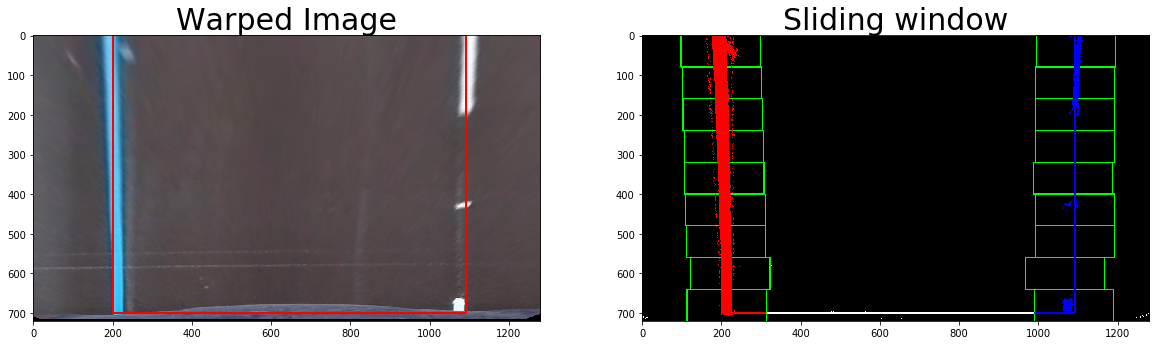

In [307]:
color_grad_transformed_img = color_gradient_transform(warped_img)
out_img, left_fitx, right_fitx,left_fit, right_fit, ploty = fit_polynomial(color_grad_transformed_img)
    

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(warped_img)
ax1.set_title('Warped Image', fontsize=30)
ax2.imshow(out_img)
ax2.set_title('Sliding window', fontsize=30)

## Pipeline


In [312]:

def measure_curvature_pixels(left_fit, right_fit, ploty):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
   
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return (left_curverad + right_curverad)/2


def warp_undist_img(undist, src, dst):
    img_size = (undist.shape[1], undist.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

def draw_on_road(img, undist, warped, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    return result

count = 1

def second_ord_poly(line, val):
    a = line[0]
    b = line[1]
    c = line[2]
    formula = (a*val**2) + (b*val) + c

    return formula

def get_offset(img, left_fit, right_fit):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    mid = img.shape[1]/2
    
    left_line_base = second_ord_poly(left_fit, img.shape[0] * ym_per_pix)
    right_line_base = second_ord_poly(right_fit, img.shape[0] * ym_per_pix)
    lane_mid = (left_line_base+right_line_base)/2
    
    return np.absolute(lane_mid - mid) * xm_per_pix/2


def process_image(img):

    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    warped, M, Minv = warp_undist_img(undist,np.float32(src), np.float32(dst))
    color_grad_transformed_img = color_gradient_transform(warped)
    out_img, left_fitx, right_fitx,left_fit, right_fit, ploty = fit_polynomial(color_grad_transformed_img)
    result = draw_on_road(img, undist, color_grad_transformed_img, left_fitx, right_fitx, ploty, Minv)
    rad_curvature = measure_curvature_pixels(left_fit, right_fit, ploty)  
    offset = get_offset(warped, left_fit, right_fit)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Rad: {:0.2f}; Offset: {:0.2f} m'.format(rad_curvature, offset),(100,100), font, 2,(255,255,255),5,cv2.LINE_AA)
    return result

## Test pipeline

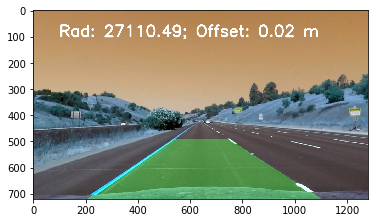

In [317]:
%matplotlib inline
images = glob.glob('./test_images/straight_lines1.jpg')
for image in images:
     input_image = cv2.imread(image)
     result = process_image(input_image)
     plt.imsave('./output_images/processed_image.jpg',result)
     plt.imshow(result)
     plt.show()

## Video Processing

In [263]:
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML


def test_image(img):
    return img

white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4").subclip(0.5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

890
7100.309176392773
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 1/1261 [00:00<15:54,  1.32it/s]

890
7100.309176392773


  0%|          | 2/1261 [00:01<16:09,  1.30it/s]

885
7374.04555732369


  0%|          | 3/1261 [00:02<15:59,  1.31it/s]

889
6246.01871400716


  0%|          | 4/1261 [00:03<16:00,  1.31it/s]

877
19530.839533672915


  0%|          | 5/1261 [00:03<15:52,  1.32it/s]

876
7644.585571402899


  0%|          | 6/1261 [00:04<16:00,  1.31it/s]

873
10155.864366468839


  1%|          | 7/1261 [00:05<16:00,  1.31it/s]

862
8716.774844106934


  1%|          | 8/1261 [00:06<15:59,  1.31it/s]

874
5581.394509910145


  1%|          | 9/1261 [00:06<15:52,  1.31it/s]

873
4358.76948254152


  1%|          | 10/1261 [00:07<15:52,  1.31it/s]

880
4340.764959681569


  1%|          | 11/1261 [00:08<15:48,  1.32it/s]

875
4279.3534884985165


  1%|          | 12/1261 [00:09<15:46,  1.32it/s]

911
5957.395216525537


  1%|          | 13/1261 [00:09<15:47,  1.32it/s]

961
10482.124055790664


  1%|          | 14/1261 [00:10<15:43,  1.32it/s]

912
20814.85580990318


  1%|          | 15/1261 [00:11<15:39,  1.33it/s]

971
10011.966079715487


  1%|▏         | 16/1261 [00:12<15:38,  1.33it/s]

863
6458.840620504776


  1%|▏         | 17/1261 [00:12<15:43,  1.32it/s]

864
5552.334848172566


  1%|▏         | 18/1261 [00:13<15:45,  1.31it/s]

861
7334.835778100916


  2%|▏         | 19/1261 [00:14<15:35,  1.33it/s]

866
8036.079415488559


  2%|▏         | 20/1261 [00:15<15:41,  1.32it/s]

888
15184.250415639824


  2%|▏         | 21/1261 [00:15<15:42,  1.32it/s]

889
7859.390078595316


  2%|▏         | 22/1261 [00:16<15:55,  1.30it/s]

877
31906.395729773656


  2%|▏         | 23/1261 [00:17<15:51,  1.30it/s]

871
12261.405481796644


  2%|▏         | 24/1261 [00:18<15:50,  1.30it/s]

869
6927.453929801652


  2%|▏         | 25/1261 [00:19<15:43,  1.31it/s]

872
17055.140680513992


  2%|▏         | 26/1261 [00:19<15:51,  1.30it/s]

910
17733.772307584513


  2%|▏         | 27/1261 [00:20<15:47,  1.30it/s]

980
170362.73395848204


  2%|▏         | 28/1261 [00:21<15:44,  1.30it/s]

989
110594.56286773944


  2%|▏         | 29/1261 [00:22<15:52,  1.29it/s]

886
37804.945040603176


  2%|▏         | 30/1261 [00:22<15:41,  1.31it/s]

886
18571.508056538165


  2%|▏         | 31/1261 [00:23<15:41,  1.31it/s]

886
9440.77127605523


  3%|▎         | 32/1261 [00:24<15:41,  1.31it/s]

882
6015.050703787449


  3%|▎         | 33/1261 [00:25<15:37,  1.31it/s]

891
5700.109624954735


  3%|▎         | 34/1261 [00:25<15:35,  1.31it/s]

798
7157.919732763052


  3%|▎         | 35/1261 [00:26<15:40,  1.30it/s]

875
187062.88590120722


  3%|▎         | 36/1261 [00:27<15:42,  1.30it/s]

983
9547.687608575448


  3%|▎         | 37/1261 [00:28<15:36,  1.31it/s]

875
6872.078854866294


  3%|▎         | 38/1261 [00:29<15:40,  1.30it/s]

870
20591.570008084956


  3%|▎         | 39/1261 [00:29<15:40,  1.30it/s]

908
9749.453939113066


  3%|▎         | 40/1261 [00:30<15:34,  1.31it/s]

908
10003.493837354175


  3%|▎         | 41/1261 [00:31<15:37,  1.30it/s]

1069
14348.396543234448


  3%|▎         | 42/1261 [00:32<15:33,  1.31it/s]

868
8473.003910844536


  3%|▎         | 43/1261 [00:32<15:31,  1.31it/s]

869
5652.481025015788


  3%|▎         | 44/1261 [00:33<15:26,  1.31it/s]

872
6148.470233972027


  4%|▎         | 45/1261 [00:34<15:29,  1.31it/s]

879
6394.10547788755


  4%|▎         | 46/1261 [00:35<15:30,  1.31it/s]

859
7279.072487166755


  4%|▎         | 47/1261 [00:35<15:38,  1.29it/s]

906
6082.7863825988725


  4%|▍         | 48/1261 [00:36<15:25,  1.31it/s]

848
5199.357899989319


  4%|▍         | 49/1261 [00:37<15:17,  1.32it/s]

851
5635.749881669586


  4%|▍         | 50/1261 [00:38<15:22,  1.31it/s]

871
5902.564969206167


  4%|▍         | 51/1261 [00:38<15:23,  1.31it/s]

841
6721.332205794535


  4%|▍         | 52/1261 [00:39<15:14,  1.32it/s]

837
5167.074933536947


  4%|▍         | 53/1261 [00:40<15:17,  1.32it/s]

866
9361.098586340751


  4%|▍         | 54/1261 [00:41<15:12,  1.32it/s]

868
17220.20512585801


  4%|▍         | 55/1261 [00:41<15:10,  1.32it/s]

868
5441.101725319208


  4%|▍         | 56/1261 [00:42<15:06,  1.33it/s]

870
5619.026682605199


  5%|▍         | 57/1261 [00:43<15:09,  1.32it/s]

871
5097.539003417156


  5%|▍         | 58/1261 [00:44<15:15,  1.31it/s]

888
6166.394386533921


  5%|▍         | 59/1261 [00:45<15:20,  1.31it/s]

839
6457.544161300178


  5%|▍         | 60/1261 [00:45<15:41,  1.28it/s]

831
5974.084913142003


  5%|▍         | 61/1261 [00:46<15:30,  1.29it/s]

855
8136.39070280024


  5%|▍         | 62/1261 [00:47<15:25,  1.30it/s]

856
11459.979815465085


  5%|▍         | 63/1261 [00:48<15:33,  1.28it/s]

756
14890.319068714101


  5%|▌         | 64/1261 [00:48<15:31,  1.29it/s]

825
26377.048830630778


  5%|▌         | 65/1261 [00:49<15:19,  1.30it/s]

834
42920.56320074652


  5%|▌         | 66/1261 [00:50<15:16,  1.30it/s]

862
59041.89094908061


  5%|▌         | 67/1261 [00:51<15:22,  1.29it/s]

862
14286.270897551029


  5%|▌         | 68/1261 [00:52<15:23,  1.29it/s]

864
48815.30382918169


  5%|▌         | 69/1261 [00:52<15:13,  1.31it/s]

862
8649.718657186531


  6%|▌         | 70/1261 [00:53<15:31,  1.28it/s]

885
6972.128050546755


  6%|▌         | 71/1261 [00:54<15:22,  1.29it/s]

900
12507.462205531216


  6%|▌         | 72/1261 [00:55<15:18,  1.29it/s]

851
1942136.52804778


  6%|▌         | 73/1261 [00:55<15:27,  1.28it/s]

848
35416.84355940557


  6%|▌         | 74/1261 [00:56<15:50,  1.25it/s]

865
11595.361623309283


  6%|▌         | 75/1261 [00:57<15:55,  1.24it/s]

867
43189.72753604373


  6%|▌         | 76/1261 [00:58<16:08,  1.22it/s]

849
7113.856125284321


  6%|▌         | 77/1261 [00:59<16:17,  1.21it/s]

855
8383.612948171727


  6%|▌         | 78/1261 [01:00<16:32,  1.19it/s]

852
10586.662357649715


  6%|▋         | 79/1261 [01:00<16:30,  1.19it/s]

959
11803.565965216685


  6%|▋         | 80/1261 [01:01<16:44,  1.18it/s]

871
7664.835111682818


  6%|▋         | 81/1261 [01:02<16:29,  1.19it/s]

870
33956.74718769744


  7%|▋         | 82/1261 [01:03<16:13,  1.21it/s]

868
31790.674521455774


  7%|▋         | 83/1261 [01:04<16:01,  1.23it/s]

889
33334.75677544031


  7%|▋         | 84/1261 [01:05<15:50,  1.24it/s]

877
29591.219658994178


  7%|▋         | 85/1261 [01:05<15:39,  1.25it/s]

887
31198.897751852142


  7%|▋         | 86/1261 [01:06<15:31,  1.26it/s]

885
13717.213088184199


  7%|▋         | 87/1261 [01:07<15:22,  1.27it/s]

885
15578.018851697132


  7%|▋         | 88/1261 [01:08<15:11,  1.29it/s]

885
11967.734192935217


  7%|▋         | 89/1261 [01:08<15:05,  1.29it/s]

888
12625.540197609913


  7%|▋         | 90/1261 [01:09<15:00,  1.30it/s]

882
19696.91920432487


  7%|▋         | 91/1261 [01:10<15:00,  1.30it/s]

875
15407.449789918472


  7%|▋         | 92/1261 [01:11<15:01,  1.30it/s]

874
18614.80507707157


  7%|▋         | 93/1261 [01:11<14:59,  1.30it/s]

871
10502.427847520135


  7%|▋         | 94/1261 [01:12<15:00,  1.30it/s]

870
7197.614834495889


  8%|▊         | 95/1261 [01:13<14:53,  1.31it/s]

885
7148.491081363514


  8%|▊         | 96/1261 [01:14<14:52,  1.31it/s]

885
10871.032867178614


  8%|▊         | 97/1261 [01:15<14:50,  1.31it/s]

864
12374.540420634847


  8%|▊         | 98/1261 [01:15<14:59,  1.29it/s]

862
12744.5937617383


  8%|▊         | 99/1261 [01:16<14:58,  1.29it/s]

866
10758.211073678918


  8%|▊         | 100/1261 [01:17<15:05,  1.28it/s]

861
18099.780416381214


  8%|▊         | 101/1261 [01:18<15:08,  1.28it/s]

823
5508.640834776696


  8%|▊         | 102/1261 [01:18<15:02,  1.28it/s]

879
10278.561706086073


  8%|▊         | 103/1261 [01:19<14:55,  1.29it/s]

856
9499.944973146894


  8%|▊         | 104/1261 [01:20<14:55,  1.29it/s]

856
8034.880381188037


  8%|▊         | 105/1261 [01:21<14:53,  1.29it/s]

861
9140.55606973097


  8%|▊         | 106/1261 [01:22<14:49,  1.30it/s]

864
6702.489324959708


  8%|▊         | 107/1261 [01:22<14:49,  1.30it/s]

868
6650.657534785419


  9%|▊         | 108/1261 [01:23<14:50,  1.30it/s]

864
6226.995912230177


  9%|▊         | 109/1261 [01:24<14:49,  1.30it/s]

891
11935.402990049957


  9%|▊         | 110/1261 [01:25<14:51,  1.29it/s]

886
8036.160771798571


  9%|▉         | 111/1261 [01:25<14:43,  1.30it/s]

896
8295.324123167353


  9%|▉         | 112/1261 [01:26<14:42,  1.30it/s]

868
7527.922836504151


  9%|▉         | 113/1261 [01:27<14:37,  1.31it/s]

864
7518.977945294908


  9%|▉         | 114/1261 [01:28<14:36,  1.31it/s]

813
16011.348229641148


  9%|▉         | 115/1261 [01:28<14:30,  1.32it/s]

867
19318.878273993345


  9%|▉         | 116/1261 [01:29<14:28,  1.32it/s]

889
17052.74332915456


  9%|▉         | 117/1261 [01:30<14:29,  1.32it/s]

867
98728.72379543897


  9%|▉         | 118/1261 [01:31<14:30,  1.31it/s]

864
9778.626059770784


  9%|▉         | 119/1261 [01:31<14:30,  1.31it/s]

864
6509.469362412356


 10%|▉         | 120/1261 [01:32<14:22,  1.32it/s]

861
5155.172742862576


 10%|▉         | 121/1261 [01:33<14:27,  1.31it/s]

874
4989.674509615709


 10%|▉         | 122/1261 [01:34<14:26,  1.31it/s]

872
5510.343379667868


 10%|▉         | 123/1261 [01:34<14:26,  1.31it/s]

858
6098.721937199691


 10%|▉         | 124/1261 [01:35<14:20,  1.32it/s]

860
8014.0647956536495


 10%|▉         | 125/1261 [01:36<14:21,  1.32it/s]

856
5970.422624410201


 10%|▉         | 126/1261 [01:37<14:20,  1.32it/s]

863
7351.207911246389


 10%|█         | 127/1261 [01:37<14:15,  1.33it/s]

870
6625.69489826736


 10%|█         | 128/1261 [01:38<14:21,  1.32it/s]

867
6401.327266432179


 10%|█         | 129/1261 [01:39<14:38,  1.29it/s]

947
6657.722911026697


 10%|█         | 130/1261 [01:40<14:49,  1.27it/s]

857
5556.5476887659


 10%|█         | 131/1261 [01:41<14:33,  1.29it/s]

856
5457.144287767467


 10%|█         | 132/1261 [01:41<14:32,  1.29it/s]

856
4851.097826591185


 11%|█         | 133/1261 [01:42<14:29,  1.30it/s]

871
4374.236789386242


 11%|█         | 134/1261 [01:43<14:29,  1.30it/s]

879
4511.897924727452


 11%|█         | 135/1261 [01:44<14:26,  1.30it/s]

838
4302.550605249591


 11%|█         | 136/1261 [01:44<14:30,  1.29it/s]

853
5618.519131436746


 11%|█         | 137/1261 [01:45<14:24,  1.30it/s]

831
4935.350043091237


 11%|█         | 138/1261 [01:46<14:25,  1.30it/s]

859
5926.236337609831


 11%|█         | 139/1261 [01:47<14:29,  1.29it/s]

850
14801.144467844719


 11%|█         | 140/1261 [01:48<14:32,  1.28it/s]

851
18734.321493523174


 11%|█         | 141/1261 [01:48<14:35,  1.28it/s]

1055
16824.20566660387


 11%|█▏        | 142/1261 [01:49<14:36,  1.28it/s]

870
48637.4629182451


 11%|█▏        | 143/1261 [01:50<14:30,  1.28it/s]

868
11578.425266259519


 11%|█▏        | 144/1261 [01:51<14:29,  1.28it/s]

865
8052.817780839861


 11%|█▏        | 145/1261 [01:52<14:32,  1.28it/s]

870
6302.627483244976


 12%|█▏        | 146/1261 [01:52<14:27,  1.28it/s]

890
5880.7534712846345


 12%|█▏        | 147/1261 [01:53<14:25,  1.29it/s]

854
5153.817476630498


 12%|█▏        | 148/1261 [01:54<14:24,  1.29it/s]

900
4962.217206603638


 12%|█▏        | 149/1261 [01:55<14:41,  1.26it/s]

841
7359.727067743184


 12%|█▏        | 150/1261 [01:55<14:37,  1.27it/s]

862
7113.029807459952


 12%|█▏        | 151/1261 [01:56<14:31,  1.27it/s]

850
6726.840694154396


 12%|█▏        | 152/1261 [01:57<14:36,  1.27it/s]

843
14161.167255035532


 12%|█▏        | 153/1261 [01:58<14:32,  1.27it/s]

846
12727.651825007157


 12%|█▏        | 154/1261 [01:59<14:27,  1.28it/s]

979
12052.763170938922


 12%|█▏        | 155/1261 [01:59<14:21,  1.28it/s]

870
35096.255766473696


 12%|█▏        | 156/1261 [02:00<14:15,  1.29it/s]

867
25822.636309811413


 12%|█▏        | 157/1261 [02:01<14:14,  1.29it/s]

869
16207.779381436132


 13%|█▎        | 158/1261 [02:02<14:14,  1.29it/s]

880
10076.35322294254


 13%|█▎        | 159/1261 [02:02<14:03,  1.31it/s]

882
8896.696804877482


 13%|█▎        | 160/1261 [02:03<13:58,  1.31it/s]

861
7185.6429374730205


 13%|█▎        | 161/1261 [02:04<13:49,  1.33it/s]

865
5996.575622961907


 13%|█▎        | 162/1261 [02:05<13:47,  1.33it/s]

870
5541.311812030444


 13%|█▎        | 163/1261 [02:05<13:47,  1.33it/s]

873
5734.494799335619


 13%|█▎        | 164/1261 [02:06<13:50,  1.32it/s]

923
6207.443473746874


 13%|█▎        | 165/1261 [02:07<13:57,  1.31it/s]

854
6028.5686118614985


 13%|█▎        | 166/1261 [02:08<13:57,  1.31it/s]

857
8627.968946425739


 13%|█▎        | 167/1261 [02:08<13:58,  1.31it/s]

866
7178.768636613386


 13%|█▎        | 168/1261 [02:09<13:54,  1.31it/s]

871
17063.34281023203


 13%|█▎        | 169/1261 [02:10<13:48,  1.32it/s]

875
14813.415879243417


 13%|█▎        | 170/1261 [02:11<13:45,  1.32it/s]

883
15681.075990086076


 14%|█▎        | 171/1261 [02:11<13:48,  1.32it/s]

904
20890.867055246705


 14%|█▎        | 172/1261 [02:12<13:45,  1.32it/s]

856
12926.65629638802


 14%|█▎        | 173/1261 [02:13<13:41,  1.32it/s]

853
6478.312901489557


 14%|█▍        | 174/1261 [02:14<13:49,  1.31it/s]

845
6250.749106555748


 14%|█▍        | 175/1261 [02:15<13:55,  1.30it/s]

842
8736.283056508153


 14%|█▍        | 176/1261 [02:15<14:01,  1.29it/s]

847
14802.970153409478


 14%|█▍        | 177/1261 [02:16<13:56,  1.30it/s]

845
48350.28243125939


 14%|█▍        | 178/1261 [02:17<13:55,  1.30it/s]

935
119623.9233950125


 14%|█▍        | 179/1261 [02:18<13:48,  1.31it/s]

879
13249.12935206282


 14%|█▍        | 180/1261 [02:18<13:47,  1.31it/s]

883
17298.86791804505


 14%|█▍        | 181/1261 [02:19<13:42,  1.31it/s]

883
14384.692439162489


 14%|█▍        | 182/1261 [02:20<13:38,  1.32it/s]

891
66368.49290111936


 15%|█▍        | 183/1261 [02:21<13:45,  1.31it/s]

893
62215.95527122462


 15%|█▍        | 184/1261 [02:21<13:51,  1.30it/s]

863
1082311.0749361892


 15%|█▍        | 185/1261 [02:22<13:51,  1.29it/s]

956
22206.634992931344


 15%|█▍        | 186/1261 [02:23<13:45,  1.30it/s]

951
8028.531182191768


 15%|█▍        | 187/1261 [02:24<13:42,  1.31it/s]

885
5249.591853024742


 15%|█▍        | 188/1261 [02:25<13:48,  1.30it/s]

841
36762.03932867687


 15%|█▍        | 189/1261 [02:25<13:47,  1.30it/s]

840
9210.801951352409


 15%|█▌        | 190/1261 [02:26<13:45,  1.30it/s]

840
5172.225096381717


 15%|█▌        | 191/1261 [02:27<13:47,  1.29it/s]

875
4430.079058902684


 15%|█▌        | 192/1261 [02:28<13:50,  1.29it/s]

876
4656.429186974181


 15%|█▌        | 193/1261 [02:28<13:54,  1.28it/s]

868
5010.785233657048


 15%|█▌        | 194/1261 [02:29<13:49,  1.29it/s]

865
4936.670924612661


 15%|█▌        | 195/1261 [02:30<13:51,  1.28it/s]

884
5490.827556028533


 16%|█▌        | 196/1261 [02:31<13:50,  1.28it/s]

850
11084.039417904747


 16%|█▌        | 197/1261 [02:32<13:49,  1.28it/s]

929
16783.457612854814


 16%|█▌        | 198/1261 [02:32<13:53,  1.27it/s]

934
38853.71733352042


 16%|█▌        | 199/1261 [02:33<13:43,  1.29it/s]

940
5199.49513570337


 16%|█▌        | 200/1261 [02:34<13:39,  1.29it/s]

891
8242.732955089032


 16%|█▌        | 201/1261 [02:35<13:29,  1.31it/s]

940
7083.436534765633


 16%|█▌        | 202/1261 [02:35<13:27,  1.31it/s]

870
187632.3887112299


 16%|█▌        | 203/1261 [02:36<13:26,  1.31it/s]

1021
31452.59850963839


 16%|█▌        | 204/1261 [02:37<13:33,  1.30it/s]

896
10125.290508149319


 16%|█▋        | 205/1261 [02:38<13:27,  1.31it/s]

890
7230.647237963129


 16%|█▋        | 206/1261 [02:38<13:26,  1.31it/s]

888
5101.624294555228


 16%|█▋        | 207/1261 [02:39<13:23,  1.31it/s]

883
4529.095148940143


 16%|█▋        | 208/1261 [02:40<13:23,  1.31it/s]

887
16752.868793766454


 17%|█▋        | 209/1261 [02:41<13:21,  1.31it/s]

773
6189.594066891929


 17%|█▋        | 210/1261 [02:41<13:21,  1.31it/s]

928
7156.293918679241


 17%|█▋        | 211/1261 [02:42<13:36,  1.29it/s]

849
7526.982315974273


 17%|█▋        | 212/1261 [02:43<13:31,  1.29it/s]

885
8721.38286468533


 17%|█▋        | 213/1261 [02:44<13:34,  1.29it/s]

848
9585.136740712516


 17%|█▋        | 214/1261 [02:45<13:28,  1.30it/s]

851
9772.766397056621


 17%|█▋        | 215/1261 [02:45<13:29,  1.29it/s]

941
22959.61786385447


 17%|█▋        | 216/1261 [02:46<13:22,  1.30it/s]

884
11584.78867640876


 17%|█▋        | 217/1261 [02:47<13:20,  1.30it/s]

883
6611.484639048082


 17%|█▋        | 218/1261 [02:48<13:24,  1.30it/s]

883
6001.584306911316


 17%|█▋        | 219/1261 [02:48<13:20,  1.30it/s]

881
4310.168462097019


 17%|█▋        | 220/1261 [02:49<13:18,  1.30it/s]

881
4217.550325392398


 18%|█▊        | 221/1261 [02:50<13:22,  1.30it/s]

818
41472.880571815826


 18%|█▊        | 222/1261 [02:51<13:18,  1.30it/s]

896
5269.4030639737875


 18%|█▊        | 223/1261 [02:52<13:15,  1.30it/s]

846
4665.799466360643


 18%|█▊        | 224/1261 [02:52<13:08,  1.31it/s]

867
5179.959827291859


 18%|█▊        | 225/1261 [02:53<13:12,  1.31it/s]

850
182083.1355673181


 18%|█▊        | 226/1261 [02:54<13:08,  1.31it/s]

849
392430.5039634196


 18%|█▊        | 227/1261 [02:55<13:14,  1.30it/s]

867
6580.986675350909


 18%|█▊        | 228/1261 [02:55<13:15,  1.30it/s]

872
8713.399544083999


 18%|█▊        | 229/1261 [02:56<13:19,  1.29it/s]

871
18983.54246912452


 18%|█▊        | 230/1261 [02:57<13:25,  1.28it/s]

872
17133.38963423106


 18%|█▊        | 231/1261 [02:58<13:22,  1.28it/s]

869
7878.68072224676


 18%|█▊        | 232/1261 [02:59<13:27,  1.27it/s]

891
7036.288636331179


 18%|█▊        | 233/1261 [02:59<13:26,  1.28it/s]

847
7569.96339280776


 19%|█▊        | 234/1261 [03:00<13:28,  1.27it/s]

955
10226.6291587922


 19%|█▊        | 235/1261 [03:01<13:29,  1.27it/s]

847
15527.420823331686


 19%|█▊        | 236/1261 [03:02<13:21,  1.28it/s]

878
8887.147514896846


 19%|█▉        | 237/1261 [03:02<13:16,  1.29it/s]

849
10770.862474988384


 19%|█▉        | 238/1261 [03:03<13:08,  1.30it/s]

849
131798.9194753369


 19%|█▉        | 239/1261 [03:04<13:05,  1.30it/s]

1051
26841.865999089092


 19%|█▉        | 240/1261 [03:05<13:08,  1.29it/s]

847
27884.82041006985


 19%|█▉        | 241/1261 [03:06<13:12,  1.29it/s]

869
9898.865095736408


 19%|█▉        | 242/1261 [03:06<13:12,  1.29it/s]

877
10658.514917112965


 19%|█▉        | 243/1261 [03:07<13:06,  1.29it/s]

873
8017.104085907891


 19%|█▉        | 244/1261 [03:08<13:21,  1.27it/s]

889
7006.312027753


 19%|█▉        | 245/1261 [03:09<13:22,  1.27it/s]

903
5985.524173640921


 20%|█▉        | 246/1261 [03:09<13:22,  1.27it/s]

971
12092.363293900029


 20%|█▉        | 247/1261 [03:10<13:09,  1.28it/s]

871
7228.515298946796


 20%|█▉        | 248/1261 [03:11<13:05,  1.29it/s]

878
6082.823453626217


 20%|█▉        | 249/1261 [03:12<12:56,  1.30it/s]

836
4787.731015837105


 20%|█▉        | 250/1261 [03:12<12:55,  1.30it/s]

841
4869.540418965633


 20%|█▉        | 251/1261 [03:13<12:52,  1.31it/s]

839
7382.386063685899


 20%|█▉        | 252/1261 [03:14<12:57,  1.30it/s]

841
12346.516452889366


 20%|██        | 253/1261 [03:15<13:03,  1.29it/s]

877
10005.65759747023


 20%|██        | 254/1261 [03:16<13:02,  1.29it/s]

878
8487.1590560211


 20%|██        | 255/1261 [03:16<12:57,  1.29it/s]

877
6209.879302891206


 20%|██        | 256/1261 [03:17<12:50,  1.30it/s]

880
5477.434046749757


 20%|██        | 257/1261 [03:18<12:51,  1.30it/s]

835
3915.0626241705204


 20%|██        | 258/1261 [03:19<12:55,  1.29it/s]

834
4108.7002382495775


 21%|██        | 259/1261 [03:19<12:53,  1.29it/s]

833
5321.546386493055


 21%|██        | 260/1261 [03:20<13:09,  1.27it/s]

873
4633.182030923537


 21%|██        | 261/1261 [03:21<13:12,  1.26it/s]

826
8877.980150050395


 21%|██        | 262/1261 [03:22<13:26,  1.24it/s]

824
6568.49205364159


 21%|██        | 263/1261 [03:23<13:26,  1.24it/s]

960
10406.270890870976


 21%|██        | 264/1261 [03:24<13:16,  1.25it/s]

963
32260.385696676225


 21%|██        | 265/1261 [03:24<13:15,  1.25it/s]

875
20250.273236323825


 21%|██        | 266/1261 [03:25<13:10,  1.26it/s]

884
11509.726542148941


 21%|██        | 267/1261 [03:26<13:16,  1.25it/s]

883
8583.591126965634


 21%|██▏       | 268/1261 [03:27<13:07,  1.26it/s]

885
6714.307639487641


 21%|██▏       | 269/1261 [03:27<12:58,  1.27it/s]

911
5766.759283683685


 21%|██▏       | 270/1261 [03:28<12:52,  1.28it/s]

846
16845.125798911205


 21%|██▏       | 271/1261 [03:29<13:02,  1.27it/s]

839
160871.67411018073


 22%|██▏       | 272/1261 [03:30<13:03,  1.26it/s]

886
6430.645079243441


 22%|██▏       | 273/1261 [03:31<12:57,  1.27it/s]

881
10527.626549571763


 22%|██▏       | 274/1261 [03:31<13:04,  1.26it/s]

841
6895.789101129378


 22%|██▏       | 275/1261 [03:32<12:56,  1.27it/s]

849
7610.766842898104


 22%|██▏       | 276/1261 [03:33<12:52,  1.27it/s]

971
8051.33316919672


 22%|██▏       | 277/1261 [03:34<12:46,  1.28it/s]

887
30187.50571676979


 22%|██▏       | 278/1261 [03:34<12:44,  1.29it/s]

887
32361.81270828333


 22%|██▏       | 279/1261 [03:35<12:37,  1.30it/s]

882
21010.687754747734


 22%|██▏       | 280/1261 [03:36<12:36,  1.30it/s]

879
7810.00868754564


 22%|██▏       | 281/1261 [03:37<12:37,  1.29it/s]

900
13689.133427659566


 22%|██▏       | 282/1261 [03:38<12:39,  1.29it/s]

886
9144.473942047138


 22%|██▏       | 283/1261 [03:38<12:39,  1.29it/s]

959
11661.53532065473


 23%|██▎       | 284/1261 [03:39<12:35,  1.29it/s]

834
7462.014152287469


 23%|██▎       | 285/1261 [03:40<12:32,  1.30it/s]

875
22410.00264292461


 23%|██▎       | 286/1261 [03:41<12:27,  1.30it/s]

850
15514.018610182567


 23%|██▎       | 287/1261 [03:41<12:29,  1.30it/s]

847
8225.96230058197


 23%|██▎       | 288/1261 [03:42<12:25,  1.31it/s]

976
8443.83358773096


 23%|██▎       | 289/1261 [03:43<12:26,  1.30it/s]

883
20519.228140592677


 23%|██▎       | 290/1261 [03:44<12:36,  1.28it/s]

885
16840.258334406193


 23%|██▎       | 291/1261 [03:45<12:36,  1.28it/s]

857
13291.261955475144


 23%|██▎       | 292/1261 [03:45<12:33,  1.29it/s]

859
10822.878396164975


 23%|██▎       | 293/1261 [03:46<12:40,  1.27it/s]

855
8570.510497527841


 23%|██▎       | 294/1261 [03:47<12:45,  1.26it/s]

856
6149.648487837019


 23%|██▎       | 295/1261 [03:48<12:39,  1.27it/s]

860
7009.60408776691


 23%|██▎       | 296/1261 [03:48<12:30,  1.29it/s]

966
6644.419726585535


 24%|██▎       | 297/1261 [03:49<12:28,  1.29it/s]

875
93498.99782606076


 24%|██▎       | 298/1261 [03:50<12:19,  1.30it/s]

809
10244.746016047193


 24%|██▎       | 299/1261 [03:51<12:21,  1.30it/s]

855
12529.595070911422


 24%|██▍       | 300/1261 [03:52<12:18,  1.30it/s]

856
22012.08462583089


 24%|██▍       | 301/1261 [03:52<12:15,  1.30it/s]

882
60671.51278132523


 24%|██▍       | 302/1261 [03:53<12:18,  1.30it/s]

885
61097.46637050528


 24%|██▍       | 303/1261 [03:54<12:20,  1.29it/s]

886
14527.567505112034


 24%|██▍       | 304/1261 [03:55<12:20,  1.29it/s]

902
10693.969646145495


 24%|██▍       | 305/1261 [03:55<12:22,  1.29it/s]

905
14534.653890597941


 24%|██▍       | 306/1261 [03:56<12:28,  1.28it/s]

815
8796.757408789184


 24%|██▍       | 307/1261 [03:57<12:28,  1.27it/s]

961
10096.569927165823


 24%|██▍       | 308/1261 [03:58<12:28,  1.27it/s]

959
11518.925918606863


 25%|██▍       | 309/1261 [03:59<12:24,  1.28it/s]

877
1315752.802145472


 25%|██▍       | 310/1261 [03:59<12:18,  1.29it/s]

846
16339.353439847175


 25%|██▍       | 311/1261 [04:00<12:10,  1.30it/s]

834
27330.34674709233


 25%|██▍       | 312/1261 [04:01<12:13,  1.29it/s]

843
131937.49465614752


 25%|██▍       | 313/1261 [04:02<12:11,  1.30it/s]

868
29124.030518898508


 25%|██▍       | 314/1261 [04:02<12:06,  1.30it/s]

868
43055.537847048734


 25%|██▍       | 315/1261 [04:03<12:00,  1.31it/s]

867
133756.94610791403


 25%|██▌       | 316/1261 [04:04<11:59,  1.31it/s]

868
35588.12243499423


 25%|██▌       | 317/1261 [04:05<12:00,  1.31it/s]

832
12583.048719336344


 25%|██▌       | 318/1261 [04:05<12:09,  1.29it/s]

829
10466.786739006302


 25%|██▌       | 319/1261 [04:06<12:02,  1.30it/s]

831
15604.324631781692


 25%|██▌       | 320/1261 [04:07<12:01,  1.30it/s]

830
22832.494423204174


 25%|██▌       | 321/1261 [04:08<12:04,  1.30it/s]

869
19864.351345855852


 26%|██▌       | 322/1261 [04:09<12:09,  1.29it/s]

835
40132.94366814017


 26%|██▌       | 323/1261 [04:09<12:04,  1.29it/s]

939
54625.34195376548


 26%|██▌       | 324/1261 [04:10<12:04,  1.29it/s]

931
77120.86803591973


 26%|██▌       | 325/1261 [04:11<12:02,  1.29it/s]

859
96087.96005371986


 26%|██▌       | 326/1261 [04:12<11:58,  1.30it/s]

862
37630.20769818071


 26%|██▌       | 327/1261 [04:12<11:51,  1.31it/s]

867
36108.514711520926


 26%|██▌       | 328/1261 [04:13<11:52,  1.31it/s]

868
85765.24657834465


 26%|██▌       | 329/1261 [04:14<11:52,  1.31it/s]

854
145326.88471490465


 26%|██▌       | 330/1261 [04:15<11:53,  1.30it/s]

924
39858.65863124695


 26%|██▌       | 331/1261 [04:15<11:55,  1.30it/s]

929
40397.7697586488


 26%|██▋       | 332/1261 [04:16<11:54,  1.30it/s]

837
66169.66658063662


 26%|██▋       | 333/1261 [04:17<11:56,  1.30it/s]

860
73456.57813893113


 26%|██▋       | 334/1261 [04:18<12:00,  1.29it/s]

833
29050.280611396673


 27%|██▋       | 335/1261 [04:19<12:00,  1.28it/s]

831
16189.05942718657


 27%|██▋       | 336/1261 [04:19<11:52,  1.30it/s]

873
15582.500967725593


 27%|██▋       | 337/1261 [04:20<11:55,  1.29it/s]

875
35791.8215661496


 27%|██▋       | 338/1261 [04:21<11:59,  1.28it/s]

876
9475.286732515257


 27%|██▋       | 339/1261 [04:22<12:06,  1.27it/s]

876
18953.196951844628


 27%|██▋       | 340/1261 [04:22<12:02,  1.27it/s]

873
68291.41134408044


 27%|██▋       | 341/1261 [04:23<11:56,  1.28it/s]

890
37186.608796934284


 27%|██▋       | 342/1261 [04:24<11:55,  1.29it/s]

921
13533.330769298664


 27%|██▋       | 343/1261 [04:25<11:57,  1.28it/s]

921
12593.859048162234


 27%|██▋       | 344/1261 [04:26<12:05,  1.26it/s]

924
12068.488682549592


 27%|██▋       | 345/1261 [04:26<12:03,  1.27it/s]

867
14917.35139022847


 27%|██▋       | 346/1261 [04:27<12:00,  1.27it/s]

848
19636.588944131312


 28%|██▊       | 347/1261 [04:28<11:55,  1.28it/s]

921
26277.786186026307


 28%|██▊       | 348/1261 [04:29<11:49,  1.29it/s]

930
6137710.106468895


 28%|██▊       | 349/1261 [04:29<11:48,  1.29it/s]

870
21568.45940715895


 28%|██▊       | 350/1261 [04:30<11:43,  1.30it/s]

872
11938.619678531097


 28%|██▊       | 351/1261 [04:31<11:35,  1.31it/s]

872
13932.92609997054


 28%|██▊       | 352/1261 [04:32<11:34,  1.31it/s]

873
13241.885678984207


 28%|██▊       | 353/1261 [04:33<11:40,  1.30it/s]

899
15641.06160044533


 28%|██▊       | 354/1261 [04:33<11:45,  1.29it/s]

868
20631.914035195852


 28%|██▊       | 355/1261 [04:34<11:38,  1.30it/s]

929
16321.347771589455


 28%|██▊       | 356/1261 [04:35<11:36,  1.30it/s]

930
44622.73525800878


 28%|██▊       | 357/1261 [04:36<11:35,  1.30it/s]

869
75682.11958835454


 28%|██▊       | 358/1261 [04:36<11:31,  1.31it/s]

929
40967.280711072875


 28%|██▊       | 359/1261 [04:37<11:36,  1.30it/s]

924
216773.76522681306


 29%|██▊       | 360/1261 [04:38<11:34,  1.30it/s]

927
43425.523781953205


 29%|██▊       | 361/1261 [04:39<11:39,  1.29it/s]

870
31488.855148696028


 29%|██▊       | 362/1261 [04:40<11:37,  1.29it/s]

864
22497.196878403724


 29%|██▉       | 363/1261 [04:40<11:33,  1.29it/s]

863
13176.015133010445


 29%|██▉       | 364/1261 [04:41<11:30,  1.30it/s]

868
11899.082485318764


 29%|██▉       | 365/1261 [04:42<11:31,  1.30it/s]

881
172262.16044753237


 29%|██▉       | 366/1261 [04:43<11:22,  1.31it/s]

915
10108.703211342941


 29%|██▉       | 367/1261 [04:43<11:22,  1.31it/s]

915
23067.61887096773


 29%|██▉       | 368/1261 [04:44<11:24,  1.30it/s]

916
8150.414805870996


 29%|██▉       | 369/1261 [04:45<11:26,  1.30it/s]

858
19557.97633019049


 29%|██▉       | 370/1261 [04:46<11:28,  1.29it/s]

916
28467.296775209546


 29%|██▉       | 371/1261 [04:46<11:25,  1.30it/s]

920
11208.7804159447


 30%|██▉       | 372/1261 [04:47<11:28,  1.29it/s]

927
5880.757414257788


 30%|██▉       | 373/1261 [04:48<11:25,  1.30it/s]

866
10904.089898127637


 30%|██▉       | 374/1261 [04:49<11:24,  1.30it/s]

866
14331.314033802115


 30%|██▉       | 375/1261 [04:49<11:20,  1.30it/s]

862
11711.580537543265


 30%|██▉       | 376/1261 [04:50<11:18,  1.30it/s]

859
13365.953510843592


 30%|██▉       | 377/1261 [04:51<11:17,  1.30it/s]

887
21470.777436014072


 30%|██▉       | 378/1261 [04:52<11:27,  1.28it/s]

864
12306.67090381245


 30%|███       | 379/1261 [04:53<11:23,  1.29it/s]

934
14023.977937012514


 30%|███       | 380/1261 [04:53<11:18,  1.30it/s]

937
9275.710238866628


 30%|███       | 381/1261 [04:54<11:19,  1.29it/s]

875
14097.629281548741


 30%|███       | 382/1261 [04:55<11:14,  1.30it/s]

871
15441.416968890448


 30%|███       | 383/1261 [04:56<11:17,  1.30it/s]

938
37533.09334419406


 30%|███       | 384/1261 [04:56<11:22,  1.28it/s]

800
25487.160313485892


 31%|███       | 385/1261 [04:57<11:19,  1.29it/s]

877
14877.865670893847


 31%|███       | 386/1261 [04:58<11:11,  1.30it/s]

878
125670.5061496751


 31%|███       | 387/1261 [04:59<11:10,  1.30it/s]

879
19291.06313133955


 31%|███       | 388/1261 [05:00<11:09,  1.30it/s]

877
20386.047093076155


 31%|███       | 389/1261 [05:00<11:03,  1.32it/s]

890
37680.04976590654


 31%|███       | 390/1261 [05:01<11:04,  1.31it/s]

876
16723.587173238426


 31%|███       | 391/1261 [05:02<11:10,  1.30it/s]

781
30003.643952860308


 31%|███       | 392/1261 [05:03<11:05,  1.30it/s]

938
6707.681310117732


 31%|███       | 393/1261 [05:03<11:03,  1.31it/s]

869
11443.63124845311


 31%|███       | 394/1261 [05:04<10:59,  1.31it/s]

928
4796021.075102589


 31%|███▏      | 395/1261 [05:05<11:02,  1.31it/s]

868
19124.604675371964


 31%|███▏      | 396/1261 [05:06<11:01,  1.31it/s]

926
15772.580797431245


 31%|███▏      | 397/1261 [05:06<10:57,  1.31it/s]

870
11256.83944530549


 32%|███▏      | 398/1261 [05:07<10:52,  1.32it/s]

871
11358.793455170942


 32%|███▏      | 399/1261 [05:08<10:54,  1.32it/s]

875
15158.73214197836


 32%|███▏      | 400/1261 [05:09<10:56,  1.31it/s]

876
81008.22638747623


 32%|███▏      | 401/1261 [05:09<10:54,  1.31it/s]

879
44440.15537459923


 32%|███▏      | 402/1261 [05:10<10:56,  1.31it/s]

887
29010.608411671412


 32%|███▏      | 403/1261 [05:11<11:02,  1.30it/s]

881
17598.302924737916


 32%|███▏      | 404/1261 [05:12<11:09,  1.28it/s]

897
10945.256497299648


 32%|███▏      | 405/1261 [05:13<11:07,  1.28it/s]

893
11856.81129597951


 32%|███▏      | 406/1261 [05:13<11:09,  1.28it/s]

894
14480.750766925195


 32%|███▏      | 407/1261 [05:14<11:01,  1.29it/s]

898
14901.002355210323


 32%|███▏      | 408/1261 [05:15<11:04,  1.28it/s]

887
22731.889057882065


 32%|███▏      | 409/1261 [05:16<11:05,  1.28it/s]

872
144746.0336938857


 33%|███▎      | 410/1261 [05:16<11:04,  1.28it/s]

868
40565.19227289194


 33%|███▎      | 411/1261 [05:17<10:58,  1.29it/s]

872
69904.51418234549


 33%|███▎      | 412/1261 [05:18<10:51,  1.30it/s]

878
58948.9979937292


 33%|███▎      | 413/1261 [05:19<10:47,  1.31it/s]

889
73006.4008736302


 33%|███▎      | 414/1261 [05:19<10:45,  1.31it/s]

888
24723.986726364306


 33%|███▎      | 415/1261 [05:20<10:54,  1.29it/s]

888
40067.29302910672


 33%|███▎      | 416/1261 [05:21<10:47,  1.30it/s]

889
61898.9602784211


 33%|███▎      | 417/1261 [05:22<10:52,  1.29it/s]

870
26379.787342749187


 33%|███▎      | 418/1261 [05:23<10:53,  1.29it/s]

892
47404.70217130878


 33%|███▎      | 419/1261 [05:23<10:54,  1.29it/s]

908
141756.58548021212


 33%|███▎      | 420/1261 [05:24<11:02,  1.27it/s]

894
78454.91214279566


 33%|███▎      | 421/1261 [05:25<10:54,  1.28it/s]

873
142235.91016200048


 33%|███▎      | 422/1261 [05:26<10:52,  1.29it/s]

870
86322.90040938946


 34%|███▎      | 423/1261 [05:27<10:52,  1.28it/s]

872
299919.04357805045


 34%|███▎      | 424/1261 [05:27<10:45,  1.30it/s]

872
54786.74686410895


 34%|███▎      | 425/1261 [05:28<10:42,  1.30it/s]

892
21943.235627930153


 34%|███▍      | 426/1261 [05:29<10:39,  1.31it/s]

891
11513.225087473158


 34%|███▍      | 427/1261 [05:30<10:35,  1.31it/s]

952
12560.866409784881


 34%|███▍      | 428/1261 [05:30<10:34,  1.31it/s]

879
14403.832824192192


 34%|███▍      | 429/1261 [05:31<10:36,  1.31it/s]

867
20009.339059016842


 34%|███▍      | 430/1261 [05:32<10:35,  1.31it/s]

873
122190.37077798745


 34%|███▍      | 431/1261 [05:33<10:36,  1.30it/s]

962
32678.370218935794


 34%|███▍      | 432/1261 [05:33<10:47,  1.28it/s]

959
61875.36979194207


 34%|███▍      | 433/1261 [05:34<10:39,  1.29it/s]

877
331238.17691816273


 34%|███▍      | 434/1261 [05:35<10:34,  1.30it/s]

876
26052.351700243682


 34%|███▍      | 435/1261 [05:36<10:29,  1.31it/s]

876
50531.57007929004


 35%|███▍      | 436/1261 [05:36<10:41,  1.29it/s]

876
57998.809493053595


 35%|███▍      | 437/1261 [05:37<10:38,  1.29it/s]

895
25861.64420717332


 35%|███▍      | 438/1261 [05:38<10:38,  1.29it/s]

890
19554.104064657702


 35%|███▍      | 439/1261 [05:39<10:36,  1.29it/s]

836
37552.307418052216


 35%|███▍      | 440/1261 [05:40<10:34,  1.29it/s]

870
43167.22905537757


 35%|███▍      | 441/1261 [05:40<10:33,  1.29it/s]

869
87611.11402829643


 35%|███▌      | 442/1261 [05:41<10:27,  1.31it/s]

863
68016.99227908535


 35%|███▌      | 443/1261 [05:42<10:24,  1.31it/s]

872
1343769.0362307334


 35%|███▌      | 444/1261 [05:43<10:26,  1.30it/s]

863
236535.49854349787


 35%|███▌      | 445/1261 [05:43<10:29,  1.30it/s]

884
129732.32892612829


 35%|███▌      | 446/1261 [05:44<10:25,  1.30it/s]

883
17037.15385923962


 35%|███▌      | 447/1261 [05:45<10:25,  1.30it/s]

880
15226.527729752932


 36%|███▌      | 448/1261 [05:46<10:22,  1.31it/s]

897
18732.907776772252


 36%|███▌      | 449/1261 [05:46<10:21,  1.31it/s]

865
10872.102169560292


 36%|███▌      | 450/1261 [05:47<10:18,  1.31it/s]

855
10592.368720888357


 36%|███▌      | 451/1261 [05:48<10:19,  1.31it/s]

856
13223.375468417351


 36%|███▌      | 452/1261 [05:49<10:17,  1.31it/s]

860
57126.56548636212


 36%|███▌      | 453/1261 [05:50<10:15,  1.31it/s]

882
118094.04784921181


 36%|███▌      | 454/1261 [05:50<10:15,  1.31it/s]

873
182028.74745561567


 36%|███▌      | 455/1261 [05:51<10:14,  1.31it/s]

977
406514.2170329359


 36%|███▌      | 456/1261 [05:52<10:17,  1.30it/s]

897
288930.73166088935


 36%|███▌      | 457/1261 [05:53<10:31,  1.27it/s]

884
159926.0782931587


 36%|███▋      | 458/1261 [05:53<10:41,  1.25it/s]

876
31192.87052714522


 36%|███▋      | 459/1261 [05:54<10:27,  1.28it/s]

880
35734.91927475852


 36%|███▋      | 460/1261 [05:55<10:27,  1.28it/s]

850
31358.575302383077


 37%|███▋      | 461/1261 [05:56<10:25,  1.28it/s]

887
36529.76328052891


 37%|███▋      | 462/1261 [05:57<10:20,  1.29it/s]

796
16106.512433685471


 37%|███▋      | 463/1261 [05:57<10:22,  1.28it/s]

890
42405.61948870783


 37%|███▋      | 464/1261 [05:58<10:25,  1.27it/s]

849
27158.46471043903


 37%|███▋      | 465/1261 [05:59<10:21,  1.28it/s]

875
196486.29402155592


 37%|███▋      | 466/1261 [06:00<10:18,  1.29it/s]

848
68283.79421238932


 37%|███▋      | 467/1261 [06:00<10:13,  1.30it/s]

970
59184.74156860146


 37%|███▋      | 468/1261 [06:01<10:09,  1.30it/s]

870
875789.372774499


 37%|███▋      | 469/1261 [06:02<10:07,  1.30it/s]

876
21546.35188858614


 37%|███▋      | 470/1261 [06:03<10:07,  1.30it/s]

879
30063.753836948883


 37%|███▋      | 471/1261 [06:04<10:11,  1.29it/s]

876
57875.80170177251


 37%|███▋      | 472/1261 [06:04<10:04,  1.31it/s]

887
123074.12120207876


 38%|███▊      | 473/1261 [06:05<10:04,  1.30it/s]

849
21931.74472406949


 38%|███▊      | 474/1261 [06:06<10:09,  1.29it/s]

875
13534.026779634105


 38%|███▊      | 475/1261 [06:07<10:09,  1.29it/s]

844
11915.906736406452


 38%|███▊      | 476/1261 [06:07<10:05,  1.30it/s]

875
10439.87726685258


 38%|███▊      | 477/1261 [06:08<10:04,  1.30it/s]

875
10969.302583494265


 38%|███▊      | 478/1261 [06:09<10:10,  1.28it/s]

883
13954.425273525005


 38%|███▊      | 479/1261 [06:10<10:13,  1.28it/s]

877
21993.689037798846


 38%|███▊      | 480/1261 [06:10<10:08,  1.28it/s]

858
22921.348016194366


 38%|███▊      | 481/1261 [06:11<10:02,  1.29it/s]

877
42790.45890396984


 38%|███▊      | 482/1261 [06:12<10:03,  1.29it/s]

881
227514.2697350513


 38%|███▊      | 483/1261 [06:13<10:08,  1.28it/s]

883
129596.08814647161


 38%|███▊      | 484/1261 [06:14<10:07,  1.28it/s]

882
48895.22698432596


 38%|███▊      | 485/1261 [06:14<10:04,  1.28it/s]

901
104670.9012208066


 39%|███▊      | 486/1261 [06:15<09:59,  1.29it/s]

872
28951.07809232458


 39%|███▊      | 487/1261 [06:16<10:02,  1.28it/s]

874
152681.43989278126


 39%|███▊      | 488/1261 [06:17<10:01,  1.29it/s]

890
52862.17257044714


 39%|███▉      | 489/1261 [06:17<09:57,  1.29it/s]

870
91976.76603138521


 39%|███▉      | 490/1261 [06:18<09:56,  1.29it/s]

874
26821.51261047874


 39%|███▉      | 491/1261 [06:19<09:56,  1.29it/s]

871
30677.65256862302


 39%|███▉      | 492/1261 [06:20<10:01,  1.28it/s]

962
2310755.0402231263


 39%|███▉      | 493/1261 [06:21<09:59,  1.28it/s]

885
29478.847407058325


 39%|███▉      | 494/1261 [06:21<09:58,  1.28it/s]

888
18994.157557129958


 39%|███▉      | 495/1261 [06:22<09:56,  1.28it/s]

887
29712.13201168477


 39%|███▉      | 496/1261 [06:23<09:52,  1.29it/s]

899
43056.10155739497


 39%|███▉      | 497/1261 [06:24<09:50,  1.29it/s]

881
85334.09259579686


 39%|███▉      | 498/1261 [06:24<09:46,  1.30it/s]

963
36085.940865503224


 40%|███▉      | 499/1261 [06:25<09:44,  1.30it/s]

872
26574.576432224156


 40%|███▉      | 500/1261 [06:26<09:47,  1.30it/s]

895
23058.659595841036


 40%|███▉      | 501/1261 [06:27<09:43,  1.30it/s]

877
17616.818590016195


 40%|███▉      | 502/1261 [06:28<09:51,  1.28it/s]

883
30731.858053131964


 40%|███▉      | 503/1261 [06:28<09:51,  1.28it/s]

883
185479.31036081407


 40%|███▉      | 504/1261 [06:29<09:54,  1.27it/s]

962
92197.885931551


 40%|████      | 505/1261 [06:30<09:54,  1.27it/s]

902
56806.650916265025


 40%|████      | 506/1261 [06:31<09:51,  1.28it/s]

900
12251.667628076371


 40%|████      | 507/1261 [06:31<09:49,  1.28it/s]

902
14875.652293015544


 40%|████      | 508/1261 [06:32<09:42,  1.29it/s]

900
86989.18617213586


 40%|████      | 509/1261 [06:33<09:43,  1.29it/s]

923
48085.26100728894


 40%|████      | 510/1261 [06:34<09:41,  1.29it/s]

885
15932.0397758492


 41%|████      | 511/1261 [06:35<09:42,  1.29it/s]

886
15895.666789969127


 41%|████      | 512/1261 [06:35<09:40,  1.29it/s]

897
21316.584044836196


 41%|████      | 513/1261 [06:36<09:39,  1.29it/s]

876
94764.18408724733


 41%|████      | 514/1261 [06:37<09:35,  1.30it/s]

974
49413.59516860606


 41%|████      | 515/1261 [06:38<09:34,  1.30it/s]

874
28884.9034955353


 41%|████      | 516/1261 [06:38<09:32,  1.30it/s]

957
20682.9226123089


 41%|████      | 517/1261 [06:39<09:26,  1.31it/s]

892
36382.07107434048


 41%|████      | 518/1261 [06:40<09:25,  1.31it/s]

891
2135158.888694923


 41%|████      | 519/1261 [06:41<09:24,  1.31it/s]

892
94696.6140435324


 41%|████      | 520/1261 [06:41<09:26,  1.31it/s]

902
44262.008313208265


 41%|████▏     | 521/1261 [06:42<09:34,  1.29it/s]

875
100874.19918667366


 41%|████▏     | 522/1261 [06:43<09:39,  1.27it/s]

881
102609.94023178879


 41%|████▏     | 523/1261 [06:44<09:37,  1.28it/s]

882
1994501.9418488042


 42%|████▏     | 524/1261 [06:45<09:34,  1.28it/s]

883
56764.44274760589


 42%|████▏     | 525/1261 [06:45<09:30,  1.29it/s]

882
37588.46268381923


 42%|████▏     | 526/1261 [06:46<09:26,  1.30it/s]

968
17619.440734258074


 42%|████▏     | 527/1261 [06:47<09:25,  1.30it/s]

899
16470.181414334216


 42%|████▏     | 528/1261 [06:48<09:22,  1.30it/s]

979
26150.354388414373


 42%|████▏     | 529/1261 [06:48<09:25,  1.30it/s]

898
12331.55447498076


 42%|████▏     | 530/1261 [06:49<09:24,  1.30it/s]

895
16080.633749182663


 42%|████▏     | 531/1261 [06:50<09:19,  1.30it/s]

884
18413.31561638238


 42%|████▏     | 532/1261 [06:51<09:17,  1.31it/s]

896
19478.7381975939


 42%|████▏     | 533/1261 [06:52<09:18,  1.30it/s]

891
29712.780784519222


 42%|████▏     | 534/1261 [06:52<09:16,  1.31it/s]

867
84730.56156121723


 42%|████▏     | 535/1261 [06:53<09:14,  1.31it/s]

882
19655.68960348668


 43%|████▎     | 536/1261 [06:54<09:10,  1.32it/s]

874
14670.887560259776


 43%|████▎     | 537/1261 [06:55<09:10,  1.31it/s]

873
13459.40198886313


 43%|████▎     | 538/1261 [06:55<09:11,  1.31it/s]

858
5970.633349264697


 43%|████▎     | 539/1261 [06:56<09:12,  1.31it/s]

893
16337.961376565607


 43%|████▎     | 540/1261 [06:57<09:11,  1.31it/s]

976
11808.510084596313


 43%|████▎     | 541/1261 [06:58<09:09,  1.31it/s]

881
9424.03062016577


 43%|████▎     | 542/1261 [06:58<09:08,  1.31it/s]

869
4668.363256536532


 43%|████▎     | 543/1261 [06:59<09:14,  1.30it/s]

875
5149.010209514276


 43%|████▎     | 544/1261 [07:00<09:16,  1.29it/s]

882
167295.0495345812


 43%|████▎     | 545/1261 [07:01<09:21,  1.27it/s]

875
21303.855099565484


 43%|████▎     | 546/1261 [07:02<09:37,  1.24it/s]

895
13178.491605324132


 43%|████▎     | 547/1261 [07:02<09:26,  1.26it/s]

895
21545.18214683156


 43%|████▎     | 548/1261 [07:03<09:25,  1.26it/s]

964
9368.864081676935


 44%|████▎     | 549/1261 [07:04<09:19,  1.27it/s]

887
8452.095005742229


 44%|████▎     | 550/1261 [07:05<09:21,  1.27it/s]

966
45804.336603579395


 44%|████▎     | 551/1261 [07:06<09:18,  1.27it/s]

885
3496.6520037518144


 44%|████▍     | 552/1261 [07:06<09:19,  1.27it/s]

858
6887.3853778893645


 44%|████▍     | 553/1261 [07:07<09:19,  1.26it/s]

818
5838.6140869722685


 44%|████▍     | 554/1261 [07:08<09:18,  1.27it/s]

817
14380.759429943033


 44%|████▍     | 555/1261 [07:09<09:29,  1.24it/s]

955
53092.28270582064


 44%|████▍     | 556/1261 [07:10<09:29,  1.24it/s]

918
9153.945450877849


 44%|████▍     | 557/1261 [07:10<09:32,  1.23it/s]

887
4097.048617738866


 44%|████▍     | 558/1261 [07:11<09:30,  1.23it/s]

917
15403.186518877239


 44%|████▍     | 559/1261 [07:12<09:38,  1.21it/s]

926
19373.878157826464


 44%|████▍     | 560/1261 [07:13<09:34,  1.22it/s]

941
7334.20822219078


 44%|████▍     | 561/1261 [07:14<09:35,  1.22it/s]

976
7957.147257609138


 45%|████▍     | 562/1261 [07:14<09:34,  1.22it/s]

974
4577.544476378138


 45%|████▍     | 563/1261 [07:15<09:32,  1.22it/s]

959
4395.542896446481


 45%|████▍     | 564/1261 [07:16<09:28,  1.23it/s]

985
6963.1986608471025


 45%|████▍     | 565/1261 [07:17<09:21,  1.24it/s]

983
24213.25419115837


 45%|████▍     | 566/1261 [07:18<09:14,  1.25it/s]

1046
18122.412422894326


 45%|████▍     | 567/1261 [07:18<09:12,  1.26it/s]

1033
12053.128454281312


 45%|████▌     | 568/1261 [07:19<09:09,  1.26it/s]

919
219696.61217600518


 45%|████▌     | 569/1261 [07:20<09:10,  1.26it/s]

904
6511.126337689854


 45%|████▌     | 570/1261 [07:21<09:14,  1.25it/s]

910
18269.464794010906


 45%|████▌     | 571/1261 [07:22<09:14,  1.24it/s]

923
6824.924692114248


 45%|████▌     | 572/1261 [07:22<09:15,  1.24it/s]

920
3629.718655999761


 45%|████▌     | 573/1261 [07:23<09:09,  1.25it/s]

915
5071.912818870522


 46%|████▌     | 574/1261 [07:24<09:05,  1.26it/s]

914
6131.4729256980645


 46%|████▌     | 575/1261 [07:25<09:08,  1.25it/s]

924
43881.551521061294


 46%|████▌     | 576/1261 [07:26<09:07,  1.25it/s]

900
46700.48825768142


 46%|████▌     | 577/1261 [07:26<09:08,  1.25it/s]

1061
17219.119815604983


 46%|████▌     | 578/1261 [07:27<08:59,  1.27it/s]

797
29912.06743711425


 46%|████▌     | 579/1261 [07:28<09:00,  1.26it/s]

840
5091.570253846813


 46%|████▌     | 580/1261 [07:29<08:59,  1.26it/s]

937
352110.0501900722


 46%|████▌     | 581/1261 [07:30<09:01,  1.26it/s]

932
19203.701640261846


 46%|████▌     | 582/1261 [07:30<08:57,  1.26it/s]

919
5992.377630729592


 46%|████▌     | 583/1261 [07:31<08:59,  1.26it/s]

909
7342.737622625593


 46%|████▋     | 584/1261 [07:32<09:04,  1.24it/s]

919
4021.195946381671


 46%|████▋     | 585/1261 [07:33<09:02,  1.25it/s]

906
6354.294751226254


 46%|████▋     | 586/1261 [07:34<08:58,  1.25it/s]

904
62846.61557070306


 47%|████▋     | 587/1261 [07:34<08:56,  1.26it/s]

916
5071.655213126405


 47%|████▋     | 588/1261 [07:35<08:53,  1.26it/s]

919
12827.344660876563


 47%|████▋     | 589/1261 [07:36<08:50,  1.27it/s]

898
6159.5796021913275


 47%|████▋     | 590/1261 [07:37<08:50,  1.26it/s]

949
5608.420847579382


 47%|████▋     | 591/1261 [07:38<08:51,  1.26it/s]

933
24616.919082643777


 47%|████▋     | 592/1261 [07:38<08:51,  1.26it/s]

921
85970.90258358484


 47%|████▋     | 593/1261 [07:39<08:54,  1.25it/s]

952
41894.10282068925


 47%|████▋     | 594/1261 [07:40<08:59,  1.24it/s]

882
7406.195457948697


 47%|████▋     | 595/1261 [07:41<09:01,  1.23it/s]

917
5874.535476436087


 47%|████▋     | 596/1261 [07:42<09:02,  1.23it/s]

889
8350.515528017888


 47%|████▋     | 597/1261 [07:43<09:07,  1.21it/s]

914
5008.914486962634


 47%|████▋     | 598/1261 [07:43<09:02,  1.22it/s]

914
6067.200575510191


 48%|████▊     | 599/1261 [07:44<09:00,  1.23it/s]

910
5592.894147004454


 48%|████▊     | 600/1261 [07:45<09:04,  1.22it/s]

994
6367.250180142233


 48%|████▊     | 601/1261 [07:46<08:55,  1.23it/s]

841
17245.548082143447


 48%|████▊     | 602/1261 [07:47<08:59,  1.22it/s]

842
3665.8989585608942


 48%|████▊     | 603/1261 [07:47<08:54,  1.23it/s]

838
4749.2085232291665


 48%|████▊     | 604/1261 [07:48<08:53,  1.23it/s]

851
24286.20805086397


 48%|████▊     | 605/1261 [07:49<08:50,  1.24it/s]

925
4836.719964512498


 48%|████▊     | 606/1261 [07:50<08:52,  1.23it/s]

934
27370.205602898463


 48%|████▊     | 607/1261 [07:51<08:46,  1.24it/s]

910
6433.963939258912


 48%|████▊     | 608/1261 [07:51<08:48,  1.24it/s]

913
21031.112590406276


 48%|████▊     | 609/1261 [07:52<08:46,  1.24it/s]

912
7308.854000070055


 48%|████▊     | 610/1261 [07:53<08:50,  1.23it/s]

921
4064.9312592135057


 48%|████▊     | 611/1261 [07:54<08:45,  1.24it/s]

906
16496.473720458504


 49%|████▊     | 612/1261 [07:55<08:44,  1.24it/s]

468
6712.207820953912


 49%|████▊     | 613/1261 [07:55<08:38,  1.25it/s]

716
3302.7723569327964


 49%|████▊     | 614/1261 [07:56<08:30,  1.27it/s]

748
26983.008789828174


 49%|████▉     | 615/1261 [07:57<08:29,  1.27it/s]

700
3175.0375770144274


 49%|████▉     | 616/1261 [07:58<08:23,  1.28it/s]

487
1787.5046917281636


 49%|████▉     | 617/1261 [07:59<08:24,  1.28it/s]

774
1387.3911802175126


 49%|████▉     | 618/1261 [07:59<08:21,  1.28it/s]

1000
5580.654774519482


 49%|████▉     | 619/1261 [08:00<08:21,  1.28it/s]

988
9875.81321165882


 49%|████▉     | 620/1261 [08:01<08:18,  1.29it/s]

981
25714.061184834827


 49%|████▉     | 621/1261 [08:02<08:20,  1.28it/s]

893
9427.348302616501


 49%|████▉     | 622/1261 [08:02<08:16,  1.29it/s]

968
34613.30277971609


 49%|████▉     | 623/1261 [08:03<08:11,  1.30it/s]

908
11764.078309214416


 49%|████▉     | 624/1261 [08:04<08:04,  1.31it/s]

911
50148.95091540944


 50%|████▉     | 625/1261 [08:05<07:59,  1.33it/s]

894
46332.34714602277


 50%|████▉     | 626/1261 [08:05<07:59,  1.33it/s]

881
9739.700095146402


 50%|████▉     | 627/1261 [08:06<08:02,  1.31it/s]

882
8103.030534068349


 50%|████▉     | 628/1261 [08:07<08:03,  1.31it/s]

867
4311860.062850899


 50%|████▉     | 629/1261 [08:08<08:05,  1.30it/s]

894
3598.401526365817


 50%|████▉     | 630/1261 [08:09<08:07,  1.29it/s]

950
3328.3472703591715


 50%|█████     | 631/1261 [08:09<08:09,  1.29it/s]

946
4649.843053659487


 50%|█████     | 632/1261 [08:10<08:06,  1.29it/s]

933
5465.282541154874


 50%|█████     | 633/1261 [08:11<08:08,  1.29it/s]

923
5617.125662363835


 50%|█████     | 634/1261 [08:12<08:08,  1.28it/s]

937
13049.296963522876


 50%|█████     | 635/1261 [08:12<08:06,  1.29it/s]

926
13072.192457148212


 50%|█████     | 636/1261 [08:13<08:03,  1.29it/s]

900
11316.535461774864


 51%|█████     | 637/1261 [08:14<08:00,  1.30it/s]

876
13146.187954341764


 51%|█████     | 638/1261 [08:15<08:00,  1.30it/s]

872
17908.604660211568


 51%|█████     | 639/1261 [08:15<08:01,  1.29it/s]

879
11547.088721133723


 51%|█████     | 640/1261 [08:16<08:03,  1.29it/s]

889
10288.854057218312


 51%|█████     | 641/1261 [08:17<08:00,  1.29it/s]

906
8653.395531116643


 51%|█████     | 642/1261 [08:18<07:59,  1.29it/s]

872
72393.03927701435


 51%|█████     | 643/1261 [08:19<07:54,  1.30it/s]

936
6478.219588624987


 51%|█████     | 644/1261 [08:19<07:51,  1.31it/s]

925
9814.438079838672


 51%|█████     | 645/1261 [08:20<07:49,  1.31it/s]

883
5715.071478354519


 51%|█████     | 646/1261 [08:21<07:49,  1.31it/s]

874
7846.349097336855


 51%|█████▏    | 647/1261 [08:22<07:53,  1.30it/s]

923
5870.987471413782


 51%|█████▏    | 648/1261 [08:22<07:54,  1.29it/s]

886
9124.062740389225


 51%|█████▏    | 649/1261 [08:23<07:53,  1.29it/s]

883
9823.769609661651


 52%|█████▏    | 650/1261 [08:24<07:53,  1.29it/s]

877
12822.286712866258


 52%|█████▏    | 651/1261 [08:25<07:50,  1.30it/s]

876
13188.93759210562


 52%|█████▏    | 652/1261 [08:26<07:53,  1.29it/s]

876
14810.644554654136


 52%|█████▏    | 653/1261 [08:26<07:52,  1.29it/s]

873
17008.287167177055


 52%|█████▏    | 654/1261 [08:27<07:53,  1.28it/s]

880
14288.794943607976


 52%|█████▏    | 655/1261 [08:28<07:51,  1.29it/s]

878
11340.60623250127


 52%|█████▏    | 656/1261 [08:29<07:46,  1.30it/s]

867
12422.76293204542


 52%|█████▏    | 657/1261 [08:29<07:44,  1.30it/s]

898
11006.263720928382


 52%|█████▏    | 658/1261 [08:30<07:47,  1.29it/s]

853
9556.95406259599


 52%|█████▏    | 659/1261 [08:31<07:46,  1.29it/s]

875
9053.854749199083


 52%|█████▏    | 660/1261 [08:32<07:45,  1.29it/s]

893
7292.40694242557


 52%|█████▏    | 661/1261 [08:32<07:41,  1.30it/s]

897
6628.3967060349


 52%|█████▏    | 662/1261 [08:33<07:42,  1.29it/s]

860
6314.881565059324


 53%|█████▎    | 663/1261 [08:34<07:44,  1.29it/s]

862
17355.637396755094


 53%|█████▎    | 664/1261 [08:35<07:41,  1.29it/s]

870
113173.03321773793


 53%|█████▎    | 665/1261 [08:36<07:39,  1.30it/s]

864
125903.80156191914


 53%|█████▎    | 666/1261 [08:36<07:39,  1.30it/s]

878
21756.324818538887


 53%|█████▎    | 667/1261 [08:37<07:32,  1.31it/s]

883
5086.629393779185


 53%|█████▎    | 668/1261 [08:38<07:38,  1.29it/s]

856
5435.783518525967


 53%|█████▎    | 669/1261 [08:39<07:35,  1.30it/s]

878
4642.218150073653


 53%|█████▎    | 670/1261 [08:39<07:31,  1.31it/s]

871
5064.321324600319


 53%|█████▎    | 671/1261 [08:40<07:31,  1.31it/s]

874
4890.92719780369


 53%|█████▎    | 672/1261 [08:41<07:36,  1.29it/s]

1001
4628.686516571784


 53%|█████▎    | 673/1261 [08:42<07:32,  1.30it/s]

997
7821.554806202299


 53%|█████▎    | 674/1261 [08:43<07:33,  1.30it/s]

881
9378.085583272663


 54%|█████▎    | 675/1261 [08:43<07:33,  1.29it/s]

877
9814.14422683253


 54%|█████▎    | 676/1261 [08:44<07:32,  1.29it/s]

870
11053.432241949824


 54%|█████▎    | 677/1261 [08:45<07:31,  1.29it/s]

871
10982.7590560773


 54%|█████▍    | 678/1261 [08:46<07:29,  1.30it/s]

875
18645.849616317933


 54%|█████▍    | 679/1261 [08:46<07:30,  1.29it/s]

886
27209.361014259026


 54%|█████▍    | 680/1261 [08:47<07:29,  1.29it/s]

889
17784.5885750121


 54%|█████▍    | 681/1261 [08:48<07:28,  1.29it/s]

869
20094.97294273461


 54%|█████▍    | 682/1261 [08:49<07:28,  1.29it/s]

994
9313.946700340304


 54%|█████▍    | 683/1261 [08:49<07:27,  1.29it/s]

863
10955.732682853688


 54%|█████▍    | 684/1261 [08:50<07:26,  1.29it/s]

993
14569.450367598824


 54%|█████▍    | 685/1261 [08:51<07:23,  1.30it/s]

989
12186.531205124611


 54%|█████▍    | 686/1261 [08:52<07:26,  1.29it/s]

870
11354.14763289814


 54%|█████▍    | 687/1261 [08:53<07:22,  1.30it/s]

864
11352.858819404897


 55%|█████▍    | 688/1261 [08:53<07:22,  1.29it/s]

864
11879.42369464524


 55%|█████▍    | 689/1261 [08:54<07:21,  1.30it/s]

864
10872.452309938291


 55%|█████▍    | 690/1261 [08:55<07:21,  1.29it/s]

864
9057.903646974679


 55%|█████▍    | 691/1261 [08:56<07:20,  1.29it/s]

882
9261.372081068885


 55%|█████▍    | 692/1261 [08:56<07:23,  1.28it/s]

881
8120.423718699882


 55%|█████▍    | 693/1261 [08:57<07:19,  1.29it/s]

883
8253.36942270361


 55%|█████▌    | 694/1261 [08:58<07:20,  1.29it/s]

999
10103.811792139473


 55%|█████▌    | 695/1261 [08:59<07:15,  1.30it/s]

856
20163.656347756318


 55%|█████▌    | 696/1261 [09:00<07:16,  1.29it/s]

889
24893.073254291943


 55%|█████▌    | 697/1261 [09:00<07:15,  1.30it/s]

786
16237.409348940924


 55%|█████▌    | 698/1261 [09:01<07:12,  1.30it/s]

865
18781.538854974548


 55%|█████▌    | 699/1261 [09:02<07:14,  1.29it/s]

858
10864.726869652593


 56%|█████▌    | 700/1261 [09:03<07:15,  1.29it/s]

855
10452.958791478939


 56%|█████▌    | 701/1261 [09:03<07:12,  1.29it/s]

853
22712.634363271874


 56%|█████▌    | 702/1261 [09:04<07:09,  1.30it/s]

856
33834.43062295247


 56%|█████▌    | 703/1261 [09:05<07:06,  1.31it/s]

873
20411.04671902254


 56%|█████▌    | 704/1261 [09:06<07:06,  1.31it/s]

890
5693.984343927139


 56%|█████▌    | 705/1261 [09:06<07:12,  1.28it/s]

892
46926.95181091741


 56%|█████▌    | 706/1261 [09:07<07:13,  1.28it/s]

831
3943.070192725416


 56%|█████▌    | 707/1261 [09:08<07:11,  1.28it/s]

858
5750.347699000524


 56%|█████▌    | 708/1261 [09:09<07:13,  1.28it/s]

990
4964.999963110719


 56%|█████▌    | 709/1261 [09:10<07:09,  1.29it/s]

890
6275.197922297979


 56%|█████▋    | 710/1261 [09:10<07:11,  1.28it/s]

882
7717.148867385616


 56%|█████▋    | 711/1261 [09:11<07:07,  1.29it/s]

863
7763.464888154065


 56%|█████▋    | 712/1261 [09:12<07:05,  1.29it/s]

863
8561.251085591543


 57%|█████▋    | 713/1261 [09:13<07:03,  1.29it/s]

862
9878.331746609121


 57%|█████▋    | 714/1261 [09:13<07:03,  1.29it/s]

858
7585.341428557287


 57%|█████▋    | 715/1261 [09:14<06:58,  1.31it/s]

870
6596.3894985047955


 57%|█████▋    | 716/1261 [09:15<06:57,  1.31it/s]

863
5372.765215323947


 57%|█████▋    | 717/1261 [09:16<06:56,  1.30it/s]

863
7329.049613854844


 57%|█████▋    | 718/1261 [09:17<06:54,  1.31it/s]

863
12507.091081689738


 57%|█████▋    | 719/1261 [09:17<06:53,  1.31it/s]

855
8976.804029420435


 57%|█████▋    | 720/1261 [09:18<06:58,  1.29it/s]

885
7170.569764201208


 57%|█████▋    | 721/1261 [09:19<06:59,  1.29it/s]

934
7835.391481302562


 57%|█████▋    | 722/1261 [09:20<06:59,  1.28it/s]

909
7396.264168350631


 57%|█████▋    | 723/1261 [09:20<07:00,  1.28it/s]

883
7891.937332389696


 57%|█████▋    | 724/1261 [09:21<06:58,  1.28it/s]

866
9403.073667571014


 57%|█████▋    | 725/1261 [09:22<06:56,  1.29it/s]

869
10325.452779870084


 58%|█████▊    | 726/1261 [09:23<06:52,  1.30it/s]

955
11131.160025786809


 58%|█████▊    | 727/1261 [09:23<06:51,  1.30it/s]

866
10820.298167080475


 58%|█████▊    | 728/1261 [09:24<06:51,  1.30it/s]

882
7454.733480206603


 58%|█████▊    | 729/1261 [09:25<06:50,  1.30it/s]

912
8332.959715801111


 58%|█████▊    | 730/1261 [09:26<06:50,  1.29it/s]

866
11084.738158948516


 58%|█████▊    | 731/1261 [09:27<06:49,  1.30it/s]

860
6196.05602738923


 58%|█████▊    | 732/1261 [09:27<06:49,  1.29it/s]

882
6139.53228782049


 58%|█████▊    | 733/1261 [09:28<06:48,  1.29it/s]

875
4644.584356809601


 58%|█████▊    | 734/1261 [09:29<06:50,  1.29it/s]

981
4760.323843782108


 58%|█████▊    | 735/1261 [09:30<06:50,  1.28it/s]

973
5141.521838683674


 58%|█████▊    | 736/1261 [09:30<06:45,  1.29it/s]

854
8490.817757820128


 58%|█████▊    | 737/1261 [09:31<06:42,  1.30it/s]

854
25157.43013711176


 59%|█████▊    | 738/1261 [09:32<06:44,  1.29it/s]

854
25319.68422354708


 59%|█████▊    | 739/1261 [09:33<06:42,  1.30it/s]

877
34848.089505474425


 59%|█████▊    | 740/1261 [09:34<06:47,  1.28it/s]

970
4178.961064724137


 59%|█████▉    | 741/1261 [09:34<06:47,  1.28it/s]

793
10996.855787168386


 59%|█████▉    | 742/1261 [09:35<06:43,  1.29it/s]

871
4536.559951050218


 59%|█████▉    | 743/1261 [09:36<06:42,  1.29it/s]

846
3926.116372373756


 59%|█████▉    | 744/1261 [09:37<06:38,  1.30it/s]

840
4809.596263642517


 59%|█████▉    | 745/1261 [09:37<06:42,  1.28it/s]

862
5951.969121469211


 59%|█████▉    | 746/1261 [09:38<06:41,  1.28it/s]

976
5344.867967978122


 59%|█████▉    | 747/1261 [09:39<06:41,  1.28it/s]

877
5653.760002458324


 59%|█████▉    | 748/1261 [09:40<06:39,  1.29it/s]

856
6849.299377928166


 59%|█████▉    | 749/1261 [09:41<06:34,  1.30it/s]

855
7805.413304632788


 59%|█████▉    | 750/1261 [09:41<06:33,  1.30it/s]

855
9815.012439741464


 60%|█████▉    | 751/1261 [09:42<06:33,  1.29it/s]

846
6376.100762385682


 60%|█████▉    | 752/1261 [09:43<06:31,  1.30it/s]

867
3627.8801608750277


 60%|█████▉    | 753/1261 [09:44<06:30,  1.30it/s]

960
4356.964738559856


 60%|█████▉    | 754/1261 [09:44<06:34,  1.29it/s]

878
5785.709380353466


 60%|█████▉    | 755/1261 [09:45<06:33,  1.29it/s]

975
6781.657196724364


 60%|█████▉    | 756/1261 [09:46<06:28,  1.30it/s]

840
8383.411637926722


 60%|██████    | 757/1261 [09:47<06:25,  1.31it/s]

883
10709.80780804517


 60%|██████    | 758/1261 [09:47<06:25,  1.30it/s]

886
6958.650063956135


 60%|██████    | 759/1261 [09:48<06:21,  1.32it/s]

970
5620.18739922312


 60%|██████    | 760/1261 [09:49<06:19,  1.32it/s]

851
4758.256992133408


 60%|██████    | 761/1261 [09:50<06:21,  1.31it/s]

849
6853.0498484400105


 60%|██████    | 762/1261 [09:51<06:21,  1.31it/s]

852
6802.941974976102


 61%|██████    | 763/1261 [09:51<06:19,  1.31it/s]

851
7881.479961836438


 61%|██████    | 764/1261 [09:52<06:21,  1.30it/s]

869
5768.295277469929


 61%|██████    | 765/1261 [09:53<06:20,  1.30it/s]

967
6435.371694088012


 61%|██████    | 766/1261 [09:54<06:19,  1.30it/s]

889
8701.11151225258


 61%|██████    | 767/1261 [09:54<06:21,  1.29it/s]

860
9736.160457461167


 61%|██████    | 768/1261 [09:55<06:20,  1.30it/s]

850
7950.62693789409


 61%|██████    | 769/1261 [09:56<06:16,  1.31it/s]

882
6585.931546106085


 61%|██████    | 770/1261 [09:57<06:19,  1.29it/s]

957
5212.012022347155


 61%|██████    | 771/1261 [09:57<06:18,  1.29it/s]

933
4851.656426818668


 61%|██████    | 772/1261 [09:58<06:18,  1.29it/s]

858
4591.777599894653


 61%|██████▏   | 773/1261 [09:59<06:20,  1.28it/s]

862
7585.120083700011


 61%|██████▏   | 774/1261 [10:00<06:18,  1.29it/s]

864
5453.09319995027


 61%|██████▏   | 775/1261 [10:01<06:18,  1.29it/s]

880
6375.593270038512


 62%|██████▏   | 776/1261 [10:01<06:14,  1.29it/s]

881
2992.0527141773186


 62%|██████▏   | 777/1261 [10:02<06:14,  1.29it/s]

882
3239.914467203519


 62%|██████▏   | 778/1261 [10:03<06:13,  1.29it/s]

964
3361.459520414719


 62%|██████▏   | 779/1261 [10:04<06:11,  1.30it/s]

894
3796.885816583393


 62%|██████▏   | 780/1261 [10:04<06:11,  1.30it/s]

861
4730.038151361339


 62%|██████▏   | 781/1261 [10:05<06:08,  1.30it/s]

898
4603.54122875629


 62%|██████▏   | 782/1261 [10:06<06:08,  1.30it/s]

941
4536.8990437529355


 62%|██████▏   | 783/1261 [10:07<06:06,  1.30it/s]

900
4715.761380326032


 62%|██████▏   | 784/1261 [10:07<06:03,  1.31it/s]

874
6132.841193190705


 62%|██████▏   | 785/1261 [10:08<06:01,  1.32it/s]

876
8386.987774931546


 62%|██████▏   | 786/1261 [10:09<06:04,  1.30it/s]

876
8339.003428002648


 62%|██████▏   | 787/1261 [10:10<06:09,  1.28it/s]

878
10909.632568168578


 62%|██████▏   | 788/1261 [10:11<06:12,  1.27it/s]

891
5510.09186146327


 63%|██████▎   | 789/1261 [10:11<06:09,  1.28it/s]

962
5792.183092810967


 63%|██████▎   | 790/1261 [10:12<06:05,  1.29it/s]

965
4982.653763179611


 63%|██████▎   | 791/1261 [10:13<06:04,  1.29it/s]

859
4996.862341234172


 63%|██████▎   | 792/1261 [10:14<06:07,  1.27it/s]

857
5497.400929458199


 63%|██████▎   | 793/1261 [10:15<06:08,  1.27it/s]

963
6380.941015678801


 63%|██████▎   | 794/1261 [10:15<06:06,  1.27it/s]

959
8274.406888990161


 63%|██████▎   | 795/1261 [10:16<06:03,  1.28it/s]

934
8568.88776775617


 63%|██████▎   | 796/1261 [10:17<06:00,  1.29it/s]

855
9541.231546521714


 63%|██████▎   | 797/1261 [10:18<05:59,  1.29it/s]

855
7811.5781937842785


 63%|██████▎   | 798/1261 [10:18<05:58,  1.29it/s]

938
6598.883198226216


 63%|██████▎   | 799/1261 [10:19<05:56,  1.30it/s]

871
5439.888165306362


 63%|██████▎   | 800/1261 [10:20<05:52,  1.31it/s]

887
3421.5559823018975


 64%|██████▎   | 801/1261 [10:21<05:52,  1.31it/s]

962
3595.884177561893


 64%|██████▎   | 802/1261 [10:21<05:49,  1.31it/s]

884
5108.902767263783


 64%|██████▎   | 803/1261 [10:22<05:48,  1.31it/s]

858
9042.101453135461


 64%|██████▍   | 804/1261 [10:23<05:48,  1.31it/s]

883
40279.5786783075


 64%|██████▍   | 805/1261 [10:24<05:47,  1.31it/s]

963
15768.00150116528


 64%|██████▍   | 806/1261 [10:25<05:50,  1.30it/s]

965
11071.56491607801


 64%|██████▍   | 807/1261 [10:25<05:50,  1.29it/s]

849
14976.029812660894


 64%|██████▍   | 808/1261 [10:26<05:49,  1.30it/s]

847
384477.10265236173


 64%|██████▍   | 809/1261 [10:27<05:50,  1.29it/s]

850
12577.97417812419


 64%|██████▍   | 810/1261 [10:28<05:49,  1.29it/s]

857
12559.708582619533


 64%|██████▍   | 811/1261 [10:28<05:47,  1.29it/s]

863
7501.826802280011


 64%|██████▍   | 812/1261 [10:29<05:47,  1.29it/s]

871
4476.960375820819


 64%|██████▍   | 813/1261 [10:30<05:43,  1.31it/s]

867
5428.945921553487


 65%|██████▍   | 814/1261 [10:31<05:39,  1.31it/s]

872
7212.871277563496


 65%|██████▍   | 815/1261 [10:31<05:38,  1.32it/s]

873
12355.993220444814


 65%|██████▍   | 816/1261 [10:32<05:35,  1.33it/s]

874
10216.098914224407


 65%|██████▍   | 817/1261 [10:33<05:34,  1.33it/s]

866
7390.654079740318


 65%|██████▍   | 818/1261 [10:34<05:34,  1.32it/s]

873
6222.206284767513


 65%|██████▍   | 819/1261 [10:34<05:34,  1.32it/s]

865
5782.865413374171


 65%|██████▌   | 820/1261 [10:35<05:34,  1.32it/s]

861
7719.669475243223


 65%|██████▌   | 821/1261 [10:36<05:37,  1.30it/s]

860
7295.315984172446


 65%|██████▌   | 822/1261 [10:37<05:38,  1.30it/s]

875
6030.1534446874775


 65%|██████▌   | 823/1261 [10:38<05:38,  1.30it/s]

881
4275.395840241536


 65%|██████▌   | 824/1261 [10:38<05:34,  1.31it/s]

886
3891.9736697579265


 65%|██████▌   | 825/1261 [10:39<05:31,  1.32it/s]

879
4940.016959823229


 66%|██████▌   | 826/1261 [10:40<05:31,  1.31it/s]

884
5277.294790308735


 66%|██████▌   | 827/1261 [10:41<05:29,  1.32it/s]

863
6626.714736638761


 66%|██████▌   | 828/1261 [10:41<05:28,  1.32it/s]

871
8788.987166777373


 66%|██████▌   | 829/1261 [10:42<05:28,  1.31it/s]

871
25667.3464341184


 66%|██████▌   | 830/1261 [10:43<05:32,  1.30it/s]

863
527920.0525367977


 66%|██████▌   | 831/1261 [10:44<05:31,  1.30it/s]

859
23606.768267966472


 66%|██████▌   | 832/1261 [10:44<05:30,  1.30it/s]

856
16317.040223512788


 66%|██████▌   | 833/1261 [10:45<05:29,  1.30it/s]

944
10575.077832540355


 66%|██████▌   | 834/1261 [10:46<05:28,  1.30it/s]

881
8172.997828685481


 66%|██████▌   | 835/1261 [10:47<05:29,  1.29it/s]

871
6307.409793016576


 66%|██████▋   | 836/1261 [10:47<05:29,  1.29it/s]

880
7003.727582010826


 66%|██████▋   | 837/1261 [10:48<05:25,  1.30it/s]

872
8723.05092977507


 66%|██████▋   | 838/1261 [10:49<05:25,  1.30it/s]

861
8474.983517394237


 67%|██████▋   | 839/1261 [10:50<05:24,  1.30it/s]

868
11155.526234771183


 67%|██████▋   | 840/1261 [10:51<05:23,  1.30it/s]

930
9132.16336359946


 67%|██████▋   | 841/1261 [10:51<05:23,  1.30it/s]

816
9954.596769670208


 67%|██████▋   | 842/1261 [10:52<05:25,  1.29it/s]

880
8325.56914902055


 67%|██████▋   | 843/1261 [10:53<05:21,  1.30it/s]

874
6300.0842024827325


 67%|██████▋   | 844/1261 [10:54<05:22,  1.29it/s]

878
8561.196139858603


 67%|██████▋   | 845/1261 [10:54<05:20,  1.30it/s]

880
14817.962586605581


 67%|██████▋   | 846/1261 [10:55<05:19,  1.30it/s]

895
8990.183704448858


 67%|██████▋   | 847/1261 [10:56<05:17,  1.30it/s]

852
7405.52178388355


 67%|██████▋   | 848/1261 [10:57<05:19,  1.29it/s]

888
6256.697098383981


 67%|██████▋   | 849/1261 [10:58<05:18,  1.29it/s]

889
6095.008332494885


 67%|██████▋   | 850/1261 [10:58<05:19,  1.29it/s]

887
4895.698579962941


 67%|██████▋   | 851/1261 [10:59<05:16,  1.30it/s]

898
13417.974265522676


 68%|██████▊   | 852/1261 [11:00<05:15,  1.30it/s]

863
13181.901619214448


 68%|██████▊   | 853/1261 [11:01<05:18,  1.28it/s]

894
10382.931348675447


 68%|██████▊   | 854/1261 [11:01<05:16,  1.29it/s]

897
7445.000428340117


 68%|██████▊   | 855/1261 [11:02<05:17,  1.28it/s]

900
6729.075345157015


 68%|██████▊   | 856/1261 [11:03<05:17,  1.28it/s]

899
16515.460774883486


 68%|██████▊   | 857/1261 [11:04<05:15,  1.28it/s]

898
82884.8382603075


 68%|██████▊   | 858/1261 [11:05<05:11,  1.29it/s]

887
25749.08394004806


 68%|██████▊   | 859/1261 [11:05<05:09,  1.30it/s]

889
14280.20595579368


 68%|██████▊   | 860/1261 [11:06<05:11,  1.29it/s]

886
9095.232225392787


 68%|██████▊   | 861/1261 [11:07<05:12,  1.28it/s]

912
15532.371647846841


 68%|██████▊   | 862/1261 [11:08<05:10,  1.28it/s]

905
95639.14380567356


 68%|██████▊   | 863/1261 [11:08<05:08,  1.29it/s]

964
19387.4032960033


 69%|██████▊   | 864/1261 [11:09<05:07,  1.29it/s]

881
17477.435084420325


 69%|██████▊   | 865/1261 [11:10<05:08,  1.29it/s]

885
85369.79613493559


 69%|██████▊   | 866/1261 [11:11<05:06,  1.29it/s]

895
17236.621302707317


 69%|██████▉   | 867/1261 [11:11<05:05,  1.29it/s]

897
13329.082528377172


 69%|██████▉   | 868/1261 [11:12<05:02,  1.30it/s]

896
10292.534693598665


 69%|██████▉   | 869/1261 [11:13<04:59,  1.31it/s]

893
8820.184955491311


 69%|██████▉   | 870/1261 [11:14<04:57,  1.32it/s]

908
6954.448181839201


 69%|██████▉   | 871/1261 [11:15<04:57,  1.31it/s]

882
5068.949501474377


 69%|██████▉   | 872/1261 [11:15<04:55,  1.31it/s]

997
5724.342731402436


 69%|██████▉   | 873/1261 [11:16<04:55,  1.31it/s]

1033
7962.7540593714875


 69%|██████▉   | 874/1261 [11:17<04:55,  1.31it/s]

901
43001.79825521999


 69%|██████▉   | 875/1261 [11:18<04:54,  1.31it/s]

1038
14263.234810428468


 69%|██████▉   | 876/1261 [11:18<04:51,  1.32it/s]

870
25075.13464552212


 70%|██████▉   | 877/1261 [11:19<04:50,  1.32it/s]

910
852784.3284700942


 70%|██████▉   | 878/1261 [11:20<04:49,  1.33it/s]

902
16062.515546297414


 70%|██████▉   | 879/1261 [11:21<04:49,  1.32it/s]

899
7831.695345743348


 70%|██████▉   | 880/1261 [11:21<04:51,  1.31it/s]

899
12217.272547167275


 70%|██████▉   | 881/1261 [11:22<04:50,  1.31it/s]

918
9150.800523970793


 70%|██████▉   | 882/1261 [11:23<04:50,  1.31it/s]

897
5128.654181546628


 70%|███████   | 883/1261 [11:24<04:50,  1.30it/s]

888
7315.924034766851


 70%|███████   | 884/1261 [11:24<04:53,  1.28it/s]

885
6112.012008211061


 70%|███████   | 885/1261 [11:25<04:52,  1.29it/s]

906
5071.507617552985


 70%|███████   | 886/1261 [11:26<04:48,  1.30it/s]

889
8581.348471603336


 70%|███████   | 887/1261 [11:27<04:49,  1.29it/s]

887
8770.36504498374


 70%|███████   | 888/1261 [11:28<04:47,  1.30it/s]

889
6269.613232943071


 70%|███████   | 889/1261 [11:28<04:45,  1.30it/s]

911
6614.0118953041565


 71%|███████   | 890/1261 [11:29<04:45,  1.30it/s]

899
5917.494578334576


 71%|███████   | 891/1261 [11:30<04:42,  1.31it/s]

901
20650.33070937433


 71%|███████   | 892/1261 [11:31<04:42,  1.31it/s]

904
19283.6513079966


 71%|███████   | 893/1261 [11:31<04:43,  1.30it/s]

908
40300.40099530418


 71%|███████   | 894/1261 [11:32<04:44,  1.29it/s]

923
11443.783818247337


 71%|███████   | 895/1261 [11:33<04:46,  1.28it/s]

917
25342.15595793399


 71%|███████   | 896/1261 [11:34<04:41,  1.30it/s]

909
87171.89172287821


 71%|███████   | 897/1261 [11:34<04:41,  1.29it/s]

897
71149.00804337228


 71%|███████   | 898/1261 [11:35<04:39,  1.30it/s]

882
15113.73058956561


 71%|███████▏  | 899/1261 [11:36<04:37,  1.30it/s]

868
10588.57640174752


 71%|███████▏  | 900/1261 [11:37<04:37,  1.30it/s]

866
28552.10198079523


 71%|███████▏  | 901/1261 [11:38<04:38,  1.29it/s]

949
25195.290109469533


 72%|███████▏  | 902/1261 [11:38<04:38,  1.29it/s]

884
325317.61026415275


 72%|███████▏  | 903/1261 [11:39<04:39,  1.28it/s]

885
55732.909395446295


 72%|███████▏  | 904/1261 [11:40<04:35,  1.29it/s]

975
27322.973550285707


 72%|███████▏  | 905/1261 [11:41<04:35,  1.29it/s]

912
22650.161132164918


 72%|███████▏  | 906/1261 [11:41<04:38,  1.27it/s]

949
5835.485070015355


 72%|███████▏  | 907/1261 [11:42<04:38,  1.27it/s]

957
5578.678041468292


 72%|███████▏  | 908/1261 [11:43<04:38,  1.27it/s]

945
5953.673658227506


 72%|███████▏  | 909/1261 [11:44<04:35,  1.28it/s]

885
6779.971203173471


 72%|███████▏  | 910/1261 [11:45<04:37,  1.26it/s]

861
9909.12101075264


 72%|███████▏  | 911/1261 [11:45<04:37,  1.26it/s]

948
20725.328915793736


 72%|███████▏  | 912/1261 [11:46<04:38,  1.25it/s]

953
48063.32421828597


 72%|███████▏  | 913/1261 [11:47<04:36,  1.26it/s]

858
42412.86456954719


 72%|███████▏  | 914/1261 [11:48<04:34,  1.26it/s]

880
18832.874152531225


 73%|███████▎  | 915/1261 [11:49<04:33,  1.27it/s]

883
10353.373114129012


 73%|███████▎  | 916/1261 [11:49<04:33,  1.26it/s]

880
7690.424123192841


 73%|███████▎  | 917/1261 [11:50<04:32,  1.26it/s]

899
9037.967902149534


 73%|███████▎  | 918/1261 [11:51<04:32,  1.26it/s]

952
4522.533828864972


 73%|███████▎  | 919/1261 [11:52<04:31,  1.26it/s]

955
4851.6861742682795


 73%|███████▎  | 920/1261 [11:53<04:27,  1.28it/s]

956
5560.039922784263


 73%|███████▎  | 921/1261 [11:53<04:25,  1.28it/s]

876
4383.948878297191


 73%|███████▎  | 922/1261 [11:54<04:22,  1.29it/s]

877
5252.51696362763


 73%|███████▎  | 923/1261 [11:55<04:20,  1.30it/s]

883
8496.925332658828


 73%|███████▎  | 924/1261 [11:56<04:18,  1.30it/s]

884
7926.538910134315


 73%|███████▎  | 925/1261 [11:56<04:19,  1.29it/s]

882
8445.488480962285


 73%|███████▎  | 926/1261 [11:57<04:15,  1.31it/s]

884
7335.283094392153


 74%|███████▎  | 927/1261 [11:58<04:15,  1.31it/s]

888
7068.557282991776


 74%|███████▎  | 928/1261 [11:59<04:13,  1.32it/s]

889
7045.675145188394


 74%|███████▎  | 929/1261 [11:59<04:11,  1.32it/s]

914
9955.166355587602


 74%|███████▍  | 930/1261 [12:00<04:13,  1.30it/s]

890
7173.910610188258


 74%|███████▍  | 931/1261 [12:01<04:15,  1.29it/s]

898
9372.96069841463


 74%|███████▍  | 932/1261 [12:02<04:15,  1.29it/s]

965
4990.792556637085


 74%|███████▍  | 933/1261 [12:03<04:15,  1.29it/s]

890
15006.39339381657


 74%|███████▍  | 934/1261 [12:03<04:14,  1.29it/s]

968
131904.9845149604


 74%|███████▍  | 935/1261 [12:04<04:13,  1.28it/s]

959
1444430.8020972926


 74%|███████▍  | 936/1261 [12:05<04:11,  1.29it/s]

957
20904.65536578062


 74%|███████▍  | 937/1261 [12:06<04:12,  1.28it/s]

896
11135.193685739017


 74%|███████▍  | 938/1261 [12:06<04:13,  1.27it/s]

886
11915.514153014032


 74%|███████▍  | 939/1261 [12:07<04:10,  1.28it/s]

891
16057.332603607381


 75%|███████▍  | 940/1261 [12:08<04:09,  1.29it/s]

893
17774.58051627711


 75%|███████▍  | 941/1261 [12:09<04:07,  1.29it/s]

900
7210.668955180537


 75%|███████▍  | 942/1261 [12:10<04:05,  1.30it/s]

891
8000.373435713163


 75%|███████▍  | 943/1261 [12:10<04:09,  1.27it/s]

949
13354.536898118276


 75%|███████▍  | 944/1261 [12:11<04:08,  1.27it/s]

954
15492.62196075435


 75%|███████▍  | 945/1261 [12:12<04:05,  1.29it/s]

883
23898.991133657302


 75%|███████▌  | 946/1261 [12:13<04:05,  1.28it/s]

947
11492.665346097476


 75%|███████▌  | 947/1261 [12:13<04:04,  1.29it/s]

952
8671.010356313282


 75%|███████▌  | 948/1261 [12:14<04:03,  1.29it/s]

819
6580.699090444458


 75%|███████▌  | 949/1261 [12:15<03:59,  1.30it/s]

888
5253.113741903751


 75%|███████▌  | 950/1261 [12:16<03:57,  1.31it/s]

879
7724.503011251798


 75%|███████▌  | 951/1261 [12:17<03:58,  1.30it/s]

883
8238.582992211763


 75%|███████▌  | 952/1261 [12:17<04:01,  1.28it/s]

892
7897.084675569413


 76%|███████▌  | 953/1261 [12:18<04:06,  1.25it/s]

906
4008.91896326296


 76%|███████▌  | 954/1261 [12:19<04:06,  1.24it/s]

915
4361.360806650959


 76%|███████▌  | 955/1261 [12:20<04:03,  1.26it/s]

957
6048.45836117018


 76%|███████▌  | 956/1261 [12:21<03:59,  1.28it/s]

898
13184.57584486505


 76%|███████▌  | 957/1261 [12:21<03:56,  1.28it/s]

888
24926.518104568775


 76%|███████▌  | 958/1261 [12:22<03:55,  1.29it/s]

990
66728.4837748331


 76%|███████▌  | 959/1261 [12:23<03:54,  1.29it/s]

948
25514.67701624911


 76%|███████▌  | 960/1261 [12:24<03:54,  1.29it/s]

893
10783.7925291552


 76%|███████▌  | 961/1261 [12:24<03:53,  1.29it/s]

892
7386.261931337067


 76%|███████▋  | 962/1261 [12:25<03:50,  1.30it/s]

893
10947.538761074868


 76%|███████▋  | 963/1261 [12:26<03:49,  1.30it/s]

982
17377.84594721762


 76%|███████▋  | 964/1261 [12:27<03:47,  1.30it/s]

913
13494.751500390004


 77%|███████▋  | 965/1261 [12:27<03:46,  1.31it/s]

911
4114.340139836856


 77%|███████▋  | 966/1261 [12:28<03:43,  1.32it/s]

806
4732.02184682515


 77%|███████▋  | 967/1261 [12:29<03:42,  1.32it/s]

927
7333.157098168944


 77%|███████▋  | 968/1261 [12:30<03:42,  1.32it/s]

884
19559.01682551059


 77%|███████▋  | 969/1261 [12:30<03:43,  1.31it/s]

966
5765.0389733901475


 77%|███████▋  | 970/1261 [12:31<03:46,  1.29it/s]

954
11847.758135242946


 77%|███████▋  | 971/1261 [12:32<03:44,  1.29it/s]

954
9722.97305113815


 77%|███████▋  | 972/1261 [12:33<03:44,  1.29it/s]

895
5728.52795404653


 77%|███████▋  | 973/1261 [12:34<03:42,  1.29it/s]

890
7457.573772701738


 77%|███████▋  | 974/1261 [12:34<03:41,  1.30it/s]

892
9210.975026663991


 77%|███████▋  | 975/1261 [12:35<03:40,  1.30it/s]

891
8510.287682735972


 77%|███████▋  | 976/1261 [12:36<03:40,  1.29it/s]

906
6282.260976368415


 77%|███████▋  | 977/1261 [12:37<03:40,  1.29it/s]

912
6892.588055949059


 78%|███████▊  | 978/1261 [12:37<03:38,  1.29it/s]

921
63364.910039481634


 78%|███████▊  | 979/1261 [12:38<03:38,  1.29it/s]

915
22139.85956390792


 78%|███████▊  | 980/1261 [12:39<03:38,  1.29it/s]

883
9042.197884463289


 78%|███████▊  | 981/1261 [12:40<03:38,  1.28it/s]

914
20001.2258663798


 78%|███████▊  | 982/1261 [12:41<03:38,  1.28it/s]

909
23062.581659146497


 78%|███████▊  | 983/1261 [12:41<03:42,  1.25it/s]

918
14397.58737073162


 78%|███████▊  | 984/1261 [12:42<03:44,  1.23it/s]

873
14749.759087803794


 78%|███████▊  | 985/1261 [12:43<03:42,  1.24it/s]

875
17903.0312956812


 78%|███████▊  | 986/1261 [12:44<03:38,  1.26it/s]

930
18816.55213900102


 78%|███████▊  | 987/1261 [12:45<03:39,  1.25it/s]

877
30642.714334625533


 78%|███████▊  | 988/1261 [12:45<03:37,  1.25it/s]

320
13460.514340345355


 78%|███████▊  | 989/1261 [12:46<03:34,  1.27it/s]

439
9107.444084371498


 79%|███████▊  | 990/1261 [12:47<03:32,  1.27it/s]

301
3713.4839843084933


 79%|███████▊  | 991/1261 [12:48<03:33,  1.27it/s]

480
3139.2013307517823


 79%|███████▊  | 992/1261 [12:49<03:36,  1.24it/s]

589
3846.9052631039494


 79%|███████▊  | 993/1261 [12:49<03:36,  1.24it/s]

881
8685.448962820048


 79%|███████▉  | 994/1261 [12:50<03:35,  1.24it/s]

931
5473.442710342033


 79%|███████▉  | 995/1261 [12:51<03:34,  1.24it/s]

945
4371.019722430059


 79%|███████▉  | 996/1261 [12:52<03:35,  1.23it/s]

992
3406.6945554511635


 79%|███████▉  | 997/1261 [12:53<03:34,  1.23it/s]

977
3770.1136004977825


 79%|███████▉  | 998/1261 [12:53<03:32,  1.24it/s]

960
17404.91738350862


 79%|███████▉  | 999/1261 [12:54<03:31,  1.24it/s]

929
5213.280840364698


 79%|███████▉  | 1000/1261 [12:55<03:33,  1.22it/s]

878
2625.410619300075


 79%|███████▉  | 1001/1261 [12:56<03:32,  1.22it/s]

1021
2300.0652159771803


 79%|███████▉  | 1002/1261 [12:57<03:30,  1.23it/s]

1008
2748.0162294948764


 80%|███████▉  | 1003/1261 [12:58<03:29,  1.23it/s]

1035
6284.342836808583


 80%|███████▉  | 1004/1261 [12:58<03:30,  1.22it/s]

986
7177.7644678446595


 80%|███████▉  | 1005/1261 [12:59<03:28,  1.23it/s]

940
6812.573560868337


 80%|███████▉  | 1006/1261 [13:00<03:27,  1.23it/s]

889
5721.32132060597


 80%|███████▉  | 1007/1261 [13:01<03:25,  1.24it/s]

873
17730.859474324046


 80%|███████▉  | 1008/1261 [13:02<03:25,  1.23it/s]

944
45837.37888571937


 80%|████████  | 1009/1261 [13:02<03:25,  1.23it/s]

927
10255.66826763425


 80%|████████  | 1010/1261 [13:03<03:23,  1.23it/s]

918
8183.154487712623


 80%|████████  | 1011/1261 [13:04<03:23,  1.23it/s]

915
145054.189126089


 80%|████████  | 1012/1261 [13:05<03:22,  1.23it/s]

934
221646.6892578923


 80%|████████  | 1013/1261 [13:06<03:22,  1.23it/s]

930
25306.647589857468


 80%|████████  | 1014/1261 [13:07<03:22,  1.22it/s]

966
148219.87207066544


 80%|████████  | 1015/1261 [13:07<03:21,  1.22it/s]

991
5774.636304676801


 81%|████████  | 1016/1261 [13:08<03:20,  1.22it/s]

946
7283.819718941322


 81%|████████  | 1017/1261 [13:09<03:19,  1.22it/s]

987
27094.023550699607


 81%|████████  | 1018/1261 [13:10<03:17,  1.23it/s]

879
9186.535989314898


 81%|████████  | 1019/1261 [13:11<03:16,  1.23it/s]

944
7994.151707237169


 81%|████████  | 1020/1261 [13:11<03:15,  1.23it/s]

956
12468.971908655698


 81%|████████  | 1021/1261 [13:12<03:13,  1.24it/s]

942
6051.627958395904


 81%|████████  | 1022/1261 [13:13<03:12,  1.24it/s]

944
6788.559091254296


 81%|████████  | 1023/1261 [13:14<03:12,  1.24it/s]

948
5951.414097758257


 81%|████████  | 1024/1261 [13:15<03:11,  1.24it/s]

946
157685.2687918988


 81%|████████▏ | 1025/1261 [13:15<03:10,  1.24it/s]

888
20530.6329207056


 81%|████████▏ | 1026/1261 [13:16<03:09,  1.24it/s]

1096
22000.339530271023


 81%|████████▏ | 1027/1261 [13:17<03:08,  1.24it/s]

1087
24691.961096383275


 82%|████████▏ | 1028/1261 [13:18<03:09,  1.23it/s]

741
52758.69461734822


 82%|████████▏ | 1029/1261 [13:19<03:08,  1.23it/s]

953
21730.694263152443


 82%|████████▏ | 1030/1261 [13:20<03:08,  1.22it/s]

944
143836.264901657


 82%|████████▏ | 1031/1261 [13:20<03:06,  1.23it/s]

938
15462.904268717775


 82%|████████▏ | 1032/1261 [13:21<03:05,  1.24it/s]

920
9955.59773750297


 82%|████████▏ | 1033/1261 [13:22<03:05,  1.23it/s]

932
15186.010652316854


 82%|████████▏ | 1034/1261 [13:23<03:05,  1.23it/s]

949
4434.529279007487


 82%|████████▏ | 1035/1261 [13:24<03:02,  1.24it/s]

934
9534.112575574081


 82%|████████▏ | 1036/1261 [13:24<03:01,  1.24it/s]

946
4020.2462821729505


 82%|████████▏ | 1037/1261 [13:25<02:59,  1.24it/s]

1091
8609.449441087352


 82%|████████▏ | 1038/1261 [13:26<02:58,  1.25it/s]

1072
120565.22905073315


 82%|████████▏ | 1039/1261 [13:27<02:56,  1.26it/s]

902
7131.328962758695


 82%|████████▏ | 1040/1261 [13:28<02:55,  1.26it/s]

877
3632.7373455562824


 83%|████████▎ | 1041/1261 [13:28<02:54,  1.26it/s]

939
1454.1595735462001


 83%|████████▎ | 1042/1261 [13:29<02:53,  1.26it/s]

765
10131.578145361824


 83%|████████▎ | 1043/1261 [13:30<02:52,  1.26it/s]

838
6951.800219061953


 83%|████████▎ | 1044/1261 [13:31<02:51,  1.26it/s]

934
2006.9945294414697


 83%|████████▎ | 1045/1261 [13:31<02:53,  1.25it/s]

782
2916.990271205661


 83%|████████▎ | 1046/1261 [13:32<02:51,  1.26it/s]

580
970.0553664604461


 83%|████████▎ | 1047/1261 [13:33<02:49,  1.26it/s]

551
1121.009778594877


 83%|████████▎ | 1048/1261 [13:34<02:49,  1.26it/s]

467
7088.414656477688


 83%|████████▎ | 1049/1261 [13:35<02:50,  1.24it/s]

822
1781.1006647415304


 83%|████████▎ | 1050/1261 [13:35<02:48,  1.25it/s]

864
10411.066182314204


 83%|████████▎ | 1051/1261 [13:36<02:45,  1.27it/s]

828
4955.174270162191


 83%|████████▎ | 1052/1261 [13:37<02:45,  1.26it/s]

927
4127.344547670324


 84%|████████▎ | 1053/1261 [13:38<02:42,  1.28it/s]

1065
1495.9632731253762


 84%|████████▎ | 1054/1261 [13:39<02:41,  1.28it/s]

881
36221.53500252044


 84%|████████▎ | 1055/1261 [13:39<02:42,  1.27it/s]

1031
2949.291739610403


 84%|████████▎ | 1056/1261 [13:40<02:41,  1.27it/s]

922
6135.128207714135


 84%|████████▍ | 1057/1261 [13:41<02:38,  1.29it/s]

917
10583.744309645594


 84%|████████▍ | 1058/1261 [13:42<02:37,  1.29it/s]

913
14038.0952812313


 84%|████████▍ | 1059/1261 [13:42<02:36,  1.29it/s]

902
35020.70199103245


 84%|████████▍ | 1060/1261 [13:43<02:35,  1.29it/s]

904
185798.4075006791


 84%|████████▍ | 1061/1261 [13:44<02:34,  1.29it/s]

880
22760.54442012175


 84%|████████▍ | 1062/1261 [13:45<02:33,  1.30it/s]

977
15425.318678172223


 84%|████████▍ | 1063/1261 [13:46<02:31,  1.30it/s]

910
13000.577518642167


 84%|████████▍ | 1064/1261 [13:46<02:32,  1.29it/s]

873
8712.493650206767


 84%|████████▍ | 1065/1261 [13:47<02:32,  1.29it/s]

968
7268.729759189283


 85%|████████▍ | 1066/1261 [13:48<02:31,  1.29it/s]

987
9773.385996717141


 85%|████████▍ | 1067/1261 [13:49<02:31,  1.28it/s]

983
10494.03304555284


 85%|████████▍ | 1068/1261 [13:49<02:30,  1.28it/s]

972
8531.885306141245


 85%|████████▍ | 1069/1261 [13:50<02:30,  1.28it/s]

895
15398.464786905439


 85%|████████▍ | 1070/1261 [13:51<02:27,  1.29it/s]

893
12847.102420306679


 85%|████████▍ | 1071/1261 [13:52<02:27,  1.29it/s]

910
10263.017993811729


 85%|████████▌ | 1072/1261 [13:53<02:25,  1.30it/s]

908
7079.6859462418


 85%|████████▌ | 1073/1261 [13:53<02:24,  1.30it/s]

979
8335.998597765585


 85%|████████▌ | 1074/1261 [13:54<02:24,  1.29it/s]

898
16732.330723575793


 85%|████████▌ | 1075/1261 [13:55<02:23,  1.30it/s]

897
18560.56005286302


 85%|████████▌ | 1076/1261 [13:56<02:23,  1.29it/s]

899
21908.400982732324


 85%|████████▌ | 1077/1261 [13:56<02:21,  1.30it/s]

890
19552.79717993498


 85%|████████▌ | 1078/1261 [13:57<02:20,  1.30it/s]

945
16284.912875495203


 86%|████████▌ | 1079/1261 [13:58<02:21,  1.29it/s]

877
12068.856035223824


 86%|████████▌ | 1080/1261 [13:59<02:22,  1.27it/s]

875
12516.59885915812


 86%|████████▌ | 1081/1261 [14:00<02:20,  1.28it/s]

880
28788.134014067473


 86%|████████▌ | 1082/1261 [14:00<02:19,  1.28it/s]

886
9667.058979845588


 86%|████████▌ | 1083/1261 [14:01<02:18,  1.29it/s]

891
6513.255622677214


 86%|████████▌ | 1084/1261 [14:02<02:17,  1.29it/s]

867
5137.964465936531


 86%|████████▌ | 1085/1261 [14:03<02:17,  1.28it/s]

989
4785.844159054245


 86%|████████▌ | 1086/1261 [14:03<02:15,  1.29it/s]

994
6034.756384823486


 86%|████████▌ | 1087/1261 [14:04<02:14,  1.30it/s]

896
5409.784218452676


 86%|████████▋ | 1088/1261 [14:05<02:13,  1.30it/s]

844
6290.887159629639


 86%|████████▋ | 1089/1261 [14:06<02:15,  1.27it/s]

941
8877.134246804655


 86%|████████▋ | 1090/1261 [14:07<02:14,  1.28it/s]

988
15336.351991069017


 87%|████████▋ | 1091/1261 [14:07<02:12,  1.28it/s]

893
11243.855895496525


 87%|████████▋ | 1092/1261 [14:08<02:12,  1.28it/s]

895
12489.480073855882


 87%|████████▋ | 1093/1261 [14:09<02:11,  1.28it/s]

895
14541.540016459145


 87%|████████▋ | 1094/1261 [14:10<02:09,  1.29it/s]

896
23825.879156609506


 87%|████████▋ | 1095/1261 [14:10<02:08,  1.29it/s]

903
5057.779666139004


 87%|████████▋ | 1096/1261 [14:11<02:09,  1.28it/s]

814
6631.46393081948


 87%|████████▋ | 1097/1261 [14:12<02:07,  1.28it/s]

879
8224.447630204791


 87%|████████▋ | 1098/1261 [14:13<02:06,  1.29it/s]

869
4917.208082801883


 87%|████████▋ | 1099/1261 [14:14<02:05,  1.29it/s]

882
5219.068281689477


 87%|████████▋ | 1100/1261 [14:14<02:03,  1.31it/s]

855
5412.123153852122


 87%|████████▋ | 1101/1261 [14:15<02:03,  1.30it/s]

974
6515.012707033361


 87%|████████▋ | 1102/1261 [14:16<02:01,  1.30it/s]

875
7944.518698913901


 87%|████████▋ | 1103/1261 [14:17<02:01,  1.30it/s]

966
14485.63085705683


 88%|████████▊ | 1104/1261 [14:17<02:00,  1.30it/s]

884
20947.62298911643


 88%|████████▊ | 1105/1261 [14:18<02:00,  1.30it/s]

885
166728.66767198246


 88%|████████▊ | 1106/1261 [14:19<02:00,  1.28it/s]

898
101686.42051627798


 88%|████████▊ | 1107/1261 [14:20<02:00,  1.28it/s]

974
32748.818266526534


 88%|████████▊ | 1108/1261 [14:20<01:59,  1.28it/s]

970
72963.202625844


 88%|████████▊ | 1109/1261 [14:21<01:59,  1.27it/s]

853
45602.83656239561


 88%|████████▊ | 1110/1261 [14:22<01:58,  1.28it/s]

877
41363.07575174214


 88%|████████▊ | 1111/1261 [14:23<01:57,  1.27it/s]

914
13552.49394783313


 88%|████████▊ | 1112/1261 [14:24<01:56,  1.28it/s]

967
10552.081316478516


 88%|████████▊ | 1113/1261 [14:24<01:56,  1.27it/s]

966
6409.845521290563


 88%|████████▊ | 1114/1261 [14:25<01:54,  1.28it/s]

879
5609.546978012037


 88%|████████▊ | 1115/1261 [14:26<01:53,  1.29it/s]

883
6946.525866097711


 89%|████████▊ | 1116/1261 [14:27<01:50,  1.31it/s]

873
4294.05554376001


 89%|████████▊ | 1117/1261 [14:28<01:51,  1.29it/s]

868
5951.393703117268


 89%|████████▊ | 1118/1261 [14:28<01:50,  1.29it/s]

871
5965.407289393108


 89%|████████▊ | 1119/1261 [14:29<01:50,  1.28it/s]

868
7527.326954112379


 89%|████████▉ | 1120/1261 [14:30<01:50,  1.28it/s]

868
8250.338211449229


 89%|████████▉ | 1121/1261 [14:31<01:48,  1.29it/s]

866
22242.090033118457


 89%|████████▉ | 1122/1261 [14:31<01:46,  1.30it/s]

926
99962.0671517429


 89%|████████▉ | 1123/1261 [14:32<01:45,  1.30it/s]

982
100633.7407031251


 89%|████████▉ | 1124/1261 [14:33<01:46,  1.28it/s]

873
48285.30473421725


 89%|████████▉ | 1125/1261 [14:34<01:45,  1.29it/s]

878
100522.2153875584


 89%|████████▉ | 1126/1261 [14:34<01:44,  1.29it/s]

972
31520.04087063448


 89%|████████▉ | 1127/1261 [14:35<01:43,  1.30it/s]

873
113872.32262850105


 89%|████████▉ | 1128/1261 [14:36<01:42,  1.30it/s]

875
18032.338229839825


 90%|████████▉ | 1129/1261 [14:37<01:41,  1.30it/s]

886
6427.938719747999


 90%|████████▉ | 1130/1261 [14:38<01:41,  1.29it/s]

872
12273.430211882707


 90%|████████▉ | 1131/1261 [14:38<01:41,  1.28it/s]

874
23983.031435757777


 90%|████████▉ | 1132/1261 [14:39<01:40,  1.28it/s]

873
9951.921485343984


 90%|████████▉ | 1133/1261 [14:40<01:40,  1.27it/s]

882
6195.850759381183


 90%|████████▉ | 1134/1261 [14:41<01:41,  1.25it/s]

879
5097.366226543466


 90%|█████████ | 1135/1261 [14:42<01:41,  1.24it/s]

982
3850.4880126850726


 90%|█████████ | 1136/1261 [14:42<01:40,  1.25it/s]

870
3813.3154505565954


 90%|█████████ | 1137/1261 [14:43<01:38,  1.26it/s]

872
7344.702352565457


 90%|█████████ | 1138/1261 [14:44<01:36,  1.28it/s]

875
13594.415265923995


 90%|█████████ | 1139/1261 [14:45<01:34,  1.29it/s]

876
13900.288951726146


 90%|█████████ | 1140/1261 [14:45<01:33,  1.29it/s]

895
9175.648420765017


 90%|█████████ | 1141/1261 [14:46<01:32,  1.30it/s]

991
9017.59064160232


 91%|█████████ | 1142/1261 [14:47<01:32,  1.29it/s]

884
15165.422884907483


 91%|█████████ | 1143/1261 [14:48<01:32,  1.27it/s]

990
41813.6703074599


 91%|█████████ | 1144/1261 [14:49<01:31,  1.27it/s]

880
52191.29864475778


 91%|█████████ | 1145/1261 [14:49<01:30,  1.28it/s]

984
86686.09268090827


 91%|█████████ | 1146/1261 [14:50<01:30,  1.28it/s]

985
93852.15281792452


 91%|█████████ | 1147/1261 [14:51<01:29,  1.28it/s]

987
26807.180222829196


 91%|█████████ | 1148/1261 [14:52<01:28,  1.28it/s]

872
33162.2873049913


 91%|█████████ | 1149/1261 [14:52<01:26,  1.29it/s]

879
74224.25413372896


 91%|█████████ | 1150/1261 [14:53<01:25,  1.31it/s]

875
80553.44080326556


 91%|█████████▏| 1151/1261 [14:54<01:24,  1.30it/s]

873
22077.03967313804


 91%|█████████▏| 1152/1261 [14:55<01:24,  1.30it/s]

874
12420.166235009483


 91%|█████████▏| 1153/1261 [14:56<01:23,  1.30it/s]

918
10978.348066899514


 92%|█████████▏| 1154/1261 [14:56<01:21,  1.31it/s]

878
14989.850744484153


 92%|█████████▏| 1155/1261 [14:57<01:21,  1.30it/s]

877
13833.86952903366


 92%|█████████▏| 1156/1261 [14:58<01:20,  1.30it/s]

884
5894.794960218566


 92%|█████████▏| 1157/1261 [14:59<01:20,  1.30it/s]

1010
5598.037766759938


 92%|█████████▏| 1158/1261 [14:59<01:19,  1.30it/s]

997
6018.218760451604


 92%|█████████▏| 1159/1261 [15:00<01:17,  1.31it/s]

893
6720.331118635886


 92%|█████████▏| 1160/1261 [15:01<01:16,  1.31it/s]

885
8119.979539350943


 92%|█████████▏| 1161/1261 [15:02<01:16,  1.31it/s]

880
16589.370909620062


 92%|█████████▏| 1162/1261 [15:02<01:16,  1.30it/s]

884
12553.836209719258


 92%|█████████▏| 1163/1261 [15:03<01:15,  1.29it/s]

900
10546.576502788312


 92%|█████████▏| 1164/1261 [15:04<01:14,  1.29it/s]

900
13700.261595127575


 92%|█████████▏| 1165/1261 [15:05<01:14,  1.30it/s]

889
10279.534252177978


 92%|█████████▏| 1166/1261 [15:05<01:13,  1.30it/s]

878
5394.396594527315


 93%|█████████▎| 1167/1261 [15:06<01:12,  1.30it/s]

879
5518.3834312496965


 93%|█████████▎| 1168/1261 [15:07<01:11,  1.30it/s]

880
3627.9122549797025


 93%|█████████▎| 1169/1261 [15:08<01:10,  1.30it/s]

999
3740.513950960424


 93%|█████████▎| 1170/1261 [15:09<01:10,  1.30it/s]

882
4866.914533224572


 93%|█████████▎| 1171/1261 [15:09<01:09,  1.29it/s]

883
8081.497273319823


 93%|█████████▎| 1172/1261 [15:10<01:08,  1.29it/s]

883
7794.251243215821


 93%|█████████▎| 1173/1261 [15:11<01:07,  1.30it/s]

886
6775.903309940968


 93%|█████████▎| 1174/1261 [15:12<01:07,  1.29it/s]

874
6421.259984025497


 93%|█████████▎| 1175/1261 [15:12<01:06,  1.30it/s]

961
8089.331953194131


 93%|█████████▎| 1176/1261 [15:13<01:06,  1.28it/s]

889
16808.117527499995


 93%|█████████▎| 1177/1261 [15:14<01:05,  1.28it/s]

895
18521.37319931931


 93%|█████████▎| 1178/1261 [15:15<01:04,  1.29it/s]

873
16225.91422803327


 93%|█████████▎| 1179/1261 [15:16<01:03,  1.29it/s]

1008
8446.252515423195


 94%|█████████▎| 1180/1261 [15:16<01:02,  1.30it/s]

1003
9346.321905317687


 94%|█████████▎| 1181/1261 [15:17<01:01,  1.30it/s]

989
10060.861175280625


 94%|█████████▎| 1182/1261 [15:18<01:01,  1.29it/s]

876
10892.648945418248


 94%|█████████▍| 1183/1261 [15:19<00:59,  1.30it/s]

878
19047.94775296117


 94%|█████████▍| 1184/1261 [15:19<00:59,  1.30it/s]

878
17521.989712883253


 94%|█████████▍| 1185/1261 [15:20<00:58,  1.31it/s]

872
94098.56095061121


 94%|█████████▍| 1186/1261 [15:21<00:57,  1.30it/s]

992
7613.271774861295


 94%|█████████▍| 1187/1261 [15:22<00:56,  1.31it/s]

988
10510.25251312061


 94%|█████████▍| 1188/1261 [15:22<00:55,  1.31it/s]

978
30013.897614748086


 94%|█████████▍| 1189/1261 [15:23<00:55,  1.29it/s]

883
281426.3133873298


 94%|█████████▍| 1190/1261 [15:24<00:55,  1.29it/s]

870
25485.925584693137


 94%|█████████▍| 1191/1261 [15:25<00:54,  1.29it/s]

862
147225.32477918832


 95%|█████████▍| 1192/1261 [15:26<00:53,  1.29it/s]

983
22196.28639650506


 95%|█████████▍| 1193/1261 [15:26<00:52,  1.30it/s]

870
7250.052790632604


 95%|█████████▍| 1194/1261 [15:27<00:51,  1.29it/s]

871
6768.201275108106


 95%|█████████▍| 1195/1261 [15:28<00:51,  1.28it/s]

864
7000.524567782031


 95%|█████████▍| 1196/1261 [15:29<00:50,  1.28it/s]

871
5726.020815465865


 95%|█████████▍| 1197/1261 [15:29<00:49,  1.29it/s]

871
4442.865244112127


 95%|█████████▌| 1198/1261 [15:30<00:48,  1.29it/s]

880
5133.966485594119


 95%|█████████▌| 1199/1261 [15:31<00:48,  1.27it/s]

892
5602.599839480654


 95%|█████████▌| 1200/1261 [15:32<00:47,  1.27it/s]

884
5970.913400189333


 95%|█████████▌| 1201/1261 [15:33<00:46,  1.28it/s]

906
6310.972688401693


 95%|█████████▌| 1202/1261 [15:33<00:45,  1.29it/s]

908
7096.963648058112


 95%|█████████▌| 1203/1261 [15:34<00:45,  1.29it/s]

909
6461.668627774921


 95%|█████████▌| 1204/1261 [15:35<00:44,  1.27it/s]

890
5523.4833377805235


 96%|█████████▌| 1205/1261 [15:36<00:43,  1.28it/s]

894
5502.045844337582


 96%|█████████▌| 1206/1261 [15:36<00:42,  1.29it/s]

882
5539.24997141673


 96%|█████████▌| 1207/1261 [15:37<00:41,  1.29it/s]

875
6872.5550954584905


 96%|█████████▌| 1208/1261 [15:38<00:41,  1.29it/s]

874
12422.174836546936


 96%|█████████▌| 1209/1261 [15:39<00:40,  1.28it/s]

968
30881.080254779852


 96%|█████████▌| 1210/1261 [15:40<00:40,  1.27it/s]

966
22359.885521424156


 96%|█████████▌| 1211/1261 [15:40<00:39,  1.28it/s]

858
9048.824467127723


 96%|█████████▌| 1212/1261 [15:41<00:38,  1.28it/s]

885
4803.998161145597


 96%|█████████▌| 1213/1261 [15:42<00:37,  1.28it/s]

958
3616.096402405049


 96%|█████████▋| 1214/1261 [15:43<00:36,  1.28it/s]

967
3266.1071588958293


 96%|█████████▋| 1215/1261 [15:44<00:35,  1.28it/s]

964
3341.894344326002


 96%|█████████▋| 1216/1261 [15:44<00:34,  1.30it/s]

869
3826.828327034008


 97%|█████████▋| 1217/1261 [15:45<00:33,  1.30it/s]

868
5791.4820566330145


 97%|█████████▋| 1218/1261 [15:46<00:33,  1.30it/s]

870
7668.432555623073


 97%|█████████▋| 1219/1261 [15:47<00:32,  1.30it/s]

888
6060.195111172154


 97%|█████████▋| 1220/1261 [15:47<00:31,  1.30it/s]

888
6697.024386040924


 97%|█████████▋| 1221/1261 [15:48<00:30,  1.30it/s]

964
13676.704960587675


 97%|█████████▋| 1222/1261 [15:49<00:30,  1.29it/s]

962
11504.431339120993


 97%|█████████▋| 1223/1261 [15:50<00:29,  1.30it/s]

858
7660.711929878958


 97%|█████████▋| 1224/1261 [15:50<00:28,  1.30it/s]

957
5267.468980785222


 97%|█████████▋| 1225/1261 [15:51<00:27,  1.31it/s]

954
4346.367821542335


 97%|█████████▋| 1226/1261 [15:52<00:26,  1.30it/s]

955
4044.071032364895


 97%|█████████▋| 1227/1261 [15:53<00:26,  1.30it/s]

874
4074.192930373506


 97%|█████████▋| 1228/1261 [15:53<00:25,  1.31it/s]

874
5898.995824422338


 97%|█████████▋| 1229/1261 [15:54<00:24,  1.31it/s]

880
12660.250354267035


 98%|█████████▊| 1230/1261 [15:55<00:23,  1.30it/s]

902
10372.327315906114


 98%|█████████▊| 1231/1261 [15:56<00:23,  1.30it/s]

879
13386.187192256955


 98%|█████████▊| 1232/1261 [15:57<00:22,  1.30it/s]

976
32180.515603571643


 98%|█████████▊| 1233/1261 [15:57<00:21,  1.30it/s]

978
19690.440360912828


 98%|█████████▊| 1234/1261 [15:58<00:20,  1.30it/s]

868
53436.69375100845


 98%|█████████▊| 1235/1261 [15:59<00:20,  1.29it/s]

884
18469.97722173659


 98%|█████████▊| 1236/1261 [16:00<00:19,  1.28it/s]

951
5783.425683112904


 98%|█████████▊| 1237/1261 [16:00<00:18,  1.29it/s]

884
4692.314110761499


 98%|█████████▊| 1238/1261 [16:01<00:17,  1.30it/s]

877
4247.400631758923


 98%|█████████▊| 1239/1261 [16:02<00:16,  1.30it/s]

962
5702.725604143774


 98%|█████████▊| 1240/1261 [16:03<00:16,  1.31it/s]

873
56631.58819437413


 98%|█████████▊| 1241/1261 [16:04<00:15,  1.29it/s]

889
18857.20715185862


 98%|█████████▊| 1242/1261 [16:04<00:14,  1.29it/s]

892
398693.2349191374


 99%|█████████▊| 1243/1261 [16:05<00:14,  1.28it/s]

956
7609.045312457462


 99%|█████████▊| 1244/1261 [16:06<00:13,  1.29it/s]

951
5861.738168727461


 99%|█████████▊| 1245/1261 [16:07<00:12,  1.29it/s]

878
6219.389062866363


 99%|█████████▉| 1246/1261 [16:07<00:11,  1.29it/s]

866
10232.679623748514


 99%|█████████▉| 1247/1261 [16:08<00:10,  1.29it/s]

945
24386.68815167114


 99%|█████████▉| 1248/1261 [16:09<00:10,  1.29it/s]

941
7696.038456831674


 99%|█████████▉| 1249/1261 [16:10<00:09,  1.29it/s]

875
6393.195004349894


 99%|█████████▉| 1250/1261 [16:10<00:08,  1.29it/s]

873
9496.2342876855


 99%|█████████▉| 1251/1261 [16:11<00:07,  1.27it/s]

880
18425.755495374753


 99%|█████████▉| 1252/1261 [16:12<00:07,  1.28it/s]

894
21810.95403323277


 99%|█████████▉| 1253/1261 [16:13<00:06,  1.30it/s]

878
693052.8724338688


 99%|█████████▉| 1254/1261 [16:14<00:05,  1.30it/s]

872
19989.70725219362


100%|█████████▉| 1255/1261 [16:14<00:04,  1.29it/s]

957
8796.069297485199


100%|█████████▉| 1256/1261 [16:15<00:03,  1.30it/s]

881
15100.633118968573


100%|█████████▉| 1257/1261 [16:16<00:03,  1.30it/s]

885
23148.66328388469


100%|█████████▉| 1258/1261 [16:17<00:02,  1.30it/s]

873
14346.818409678439


100%|█████████▉| 1259/1261 [16:17<00:01,  1.28it/s]

959
11872.91096794822


100%|█████████▉| 1260/1261 [16:18<00:00,  1.29it/s]

889
13195.46967720565


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1h 9min 22s, sys: 5min 39s, total: 1h 15min 1s
Wall time: 16min 19s


In [264]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))